In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from process_csvs import load_ticks, calculate_ticks_pct_chng

FEE_RATE = 0.001
usd_balance = 1000
btc_balance = 0

out = Path("out")
if not out.exists():
    print("out folder does not exist")

def pct_chng(o, n):
    return (n-o)/o

In [2]:
all_ticks, a_t, train_ticks, t_t, validation_ticks, v_t = load_ticks("tick.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'tick.csv'

In [7]:
all_ticks_pct_chng = calculate_ticks_pct_chng(all_ticks)

print(all_ticks_pct_chng[0])
print(pct_chng(all_ticks[0], all_ticks[1]))

6.134598614880192e-07
6.134598614880192e-07


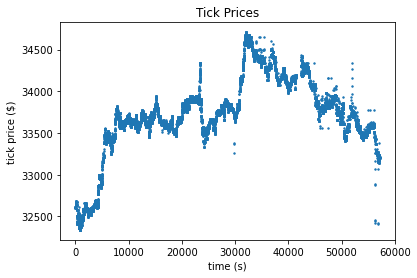

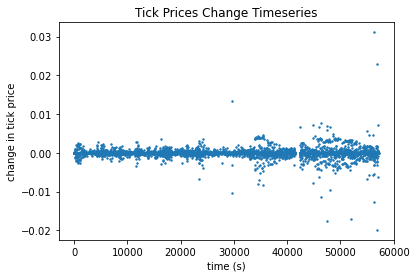

In [3]:
fig, ax = plt.subplots()
ax.scatter(t_t, train_ticks, s=2)

ax.set(xlabel='time (s)', ylabel='tick price ($)', title='Tick Prices')
plt.savefig(out/"ticks.png")
plt.show()
    
fig, ax = plt.subplots()
ax.scatter(t_t[1:], train_tick_pct_chng, s=2)

ax.set(xlabel='time (s)', ylabel='change in tick price', title='Tick Prices Change Timeseries')
plt.savefig(out/"ticks_chng_timeseries.png")
plt.show()

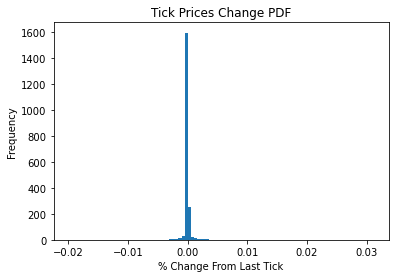

Mean:1.105576897788814e-06 Std:0.0006135213198293881


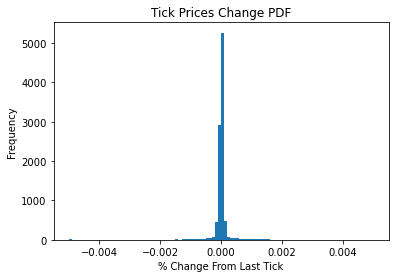

Mean:1.8269764696971173e-06 Std:0.0004585919493136196


In [4]:
#tick prices change histogram
fig, ax = plt.subplots()
ax.hist(train_tick_pct_chng, bins=100, density=True)
ax.set(xlabel='% Change From Last Tick', ylabel='Frequency', title='Tick Prices Change PDF')
plt.savefig(out/"ticks_chng_histogram.png")
plt.show()
print("Mean:{} Std:{}".format(np.mean(train_tick_pct_chng), np.std(train_tick_pct_chng)))

fig, ax = plt.subplots()
tick_pct_chng_clip = np.clip(train_tick_pct_chng, -0.005, 0.005)
ax.hist(tick_pct_chng_clip, bins=100, density=True)
ax.set(xlabel='% Change From Last Tick', ylabel='Frequency', title='Tick Prices Change PDF')
plt.savefig(out/"ticks_chng_histogram.png")
plt.show()
print("Mean:{} Std:{}".format(np.mean(tick_pct_chng_clip), np.std(tick_pct_chng_clip)))


In [5]:
# too_low = [np.abs(np.array(train_tick_pct_chng)) < 0.00005]
# too_high = [np.abs(np.array(train_tick_pct_chng)) > 0.002]

# too_low_r = np.sum(too_low)/len(train_tick_pct_chng)
# too_high_r = np.sum(too_high)/len(train_tick_pct_chng)

# print(too_low_r)
# print(too_high_r)

In [6]:
def simulation(ticks, ticks_pct_chng, base_thresh_multiplier, dynamic_thresh_multiplier, portfolio_ratio):
    base_pct_chng_mean = np.mean(ticks_pct_chng)

    usd_balance = 5000
    btc_balance = 0.05
    wallet_value = [usd_balance + btc_balance*ticks[0]]
#     fee_rate = 0.001 # not profitable at the 0.1% maker fee rate (100k - 1M in monthly volume)
#     fee_rate = 0.0008 # not profitable at the 0.08% maker fee rate (1M - 10M in monthly volume)
#     fee_rate = 0.0005 # not profitable at the 0.05% maker fee rate (10M - 50M in monthly volume)
    fee_rate = 0 # profitable at the 0.0% maker fee rate (50M+ in monthly volume)

    threshold = base_pct_chng_mean*base_thresh_multiplier

    transactions = 0
    cant_sell = 0
    cant_buy = 0
    for i,tick_cng in enumerate(ticks_pct_chng):
        prev_price = ticks[i]
        curr_price = ticks[i+1]
        
        # sell if tick change blows over sell order threshold
        if tick_cng > 0 and tick_cng > threshold:
            sell_size = max(portfolio_ratio*btc_balance, 0.001)
            buy_size = max(portfolio_ratio*usd_balance/(prev_price*(1-threshold)), 0.001)

            if i > 5:
                threshold = max(np.mean(ticks_pct_chng[i-5:i])*dynamic_thresh_multiplier, base_pct_chng_mean*base_thresh_multiplier)

            # can only sell if we have enough bitcoin
            if btc_balance > 0.001:
                # make sure sell size is <= balance
                sell_size = min(sell_size, btc_balance)
                
                btc_balance -= sell_size
                usd_balance += sell_size*prev_price*(1+threshold)
                usd_balance -= sell_size*prev_price*(1+threshold)*fee_rate
                transactions += 1
            else:
                cant_sell += 1
        # buy if tick change blows under buy order threshold
        elif tick_cng < 0 and tick_cng < -threshold:
            sell_size = max(portfolio_ratio*btc_balance, 0.001)
            buy_size = max(portfolio_ratio*usd_balance/(prev_price*(1-threshold)), 0.001)

            if i > 5:
                threshold = max(np.mean(ticks_pct_chng[i-5:i])*dynamic_thresh_multiplier, base_pct_chng_mean*base_thresh_multiplier)

            # can only buy if we have enough usd
            if usd_balance >= buy_size*prev_price*(1-threshold):
                # make sure buy size is <= usd balance / price
                buy_size = min(buy_size, usd_balance/(prev_price*(1-threshold)))
                
                btc_balance += buy_size
                usd_balance -= buy_size*prev_price*(1-threshold)
                usd_balance -= buy_size*prev_price*(1-threshold)*fee_rate
                transactions += 1
            else:
                cant_buy += 1

        wallet_value.append(usd_balance + btc_balance*curr_price)

    return wallet_value

In [7]:
# Parameters to optimize over:
#     -> base threshold multiplier (1 to 300 by steps of 25)
#     -> dynamic threshold multiplier (1 to 12 by steps of 0.5)
#     -> portfolio ratio (0.01 to 0.50 by steps of 0.01)

results = []
for btm in np.arange(0.01, 300, 25):
    for dtm in np.arange(0.01, 12, 0.5):
        for pr in np.arange(0.01, 0.51, 0.01):
            wallet_value = simulation(train_ticks, train_tick_pct_chng, btm, dtm, pr)
            returns = pct_chng(wallet_value[0], wallet_value[-1])
            results.append((returns, btm, dtm, pr))

            print("Done btm={} dtm={} pr={} returns={}".format(btm,dtm,pr,returns))
        
results.sort(key=lambda x : x[0], reverse=True)

Done btm=0.01 dtm=0.01 pr=0.01 returns=-0.014473276225434524
Done btm=0.01 dtm=0.01 pr=0.02 returns=-0.034670754001646514
Done btm=0.01 dtm=0.01 pr=0.03 returns=-0.05566622533831013
Done btm=0.01 dtm=0.01 pr=0.04 returns=-0.0755610094951545
Done btm=0.01 dtm=0.01 pr=0.05 returns=-0.09436030905094848
Done btm=0.01 dtm=0.01 pr=0.060000000000000005 returns=-0.1121279200661168
Done btm=0.01 dtm=0.01 pr=0.06999999999999999 returns=-0.1289324873324289
Done btm=0.01 dtm=0.01 pr=0.08 returns=-0.14487409284383843
Done btm=0.01 dtm=0.01 pr=0.09 returns=-0.1600584494437609
Done btm=0.01 dtm=0.01 pr=0.09999999999999999 returns=-0.1745649660995851
Done btm=0.01 dtm=0.01 pr=0.11 returns=-0.18841015508033032
Done btm=0.01 dtm=0.01 pr=0.12 returns=-0.2016422743558201
Done btm=0.01 dtm=0.01 pr=0.13 returns=-0.2143335045502502
Done btm=0.01 dtm=0.01 pr=0.14 returns=-0.22656411839500296
Done btm=0.01 dtm=0.01 pr=0.15000000000000002 returns=-0.238286111687958
Done btm=0.01 dtm=0.01 pr=0.16 returns=-0.2496

Done btm=0.01 dtm=1.01 pr=0.3 returns=-0.29657179634589115
Done btm=0.01 dtm=1.01 pr=0.31 returns=-0.3036011595353941
Done btm=0.01 dtm=1.01 pr=0.32 returns=-0.3105320870054525
Done btm=0.01 dtm=1.01 pr=0.33 returns=-0.317287558491711
Done btm=0.01 dtm=1.01 pr=0.34 returns=-0.32398347182596
Done btm=0.01 dtm=1.01 pr=0.35000000000000003 returns=-0.3306442245146728
Done btm=0.01 dtm=1.01 pr=0.36000000000000004 returns=-0.33706109608987256
Done btm=0.01 dtm=1.01 pr=0.37 returns=-0.34341374873787256
Done btm=0.01 dtm=1.01 pr=0.38 returns=-0.34979331050649237
Done btm=0.01 dtm=1.01 pr=0.39 returns=-0.3560315662302777
Done btm=0.01 dtm=1.01 pr=0.4 returns=-0.3620486888741176
Done btm=0.01 dtm=1.01 pr=0.41000000000000003 returns=-0.36805094979320807
Done btm=0.01 dtm=1.01 pr=0.42000000000000004 returns=-0.37406200588270955
Done btm=0.01 dtm=1.01 pr=0.43 returns=-0.37999502376842587
Done btm=0.01 dtm=1.01 pr=0.44 returns=-0.38570628654377237
Done btm=0.01 dtm=1.01 pr=0.45 returns=-0.3913561306

Done btm=0.01 dtm=2.51 pr=0.11 returns=-0.05193187512287138
Done btm=0.01 dtm=2.51 pr=0.12 returns=-0.05784705654453864
Done btm=0.01 dtm=2.51 pr=0.13 returns=-0.06367000590257144
Done btm=0.01 dtm=2.51 pr=0.14 returns=-0.06940813360133637
Done btm=0.01 dtm=2.51 pr=0.15000000000000002 returns=-0.07506800821320601
Done btm=0.01 dtm=2.51 pr=0.16 returns=-0.08065507846066924
Done btm=0.01 dtm=2.51 pr=0.17 returns=-0.08617204733463123
Done btm=0.01 dtm=2.51 pr=0.18000000000000002 returns=-0.09162157129725386
Done btm=0.01 dtm=2.51 pr=0.19 returns=-0.09700552179744373
Done btm=0.01 dtm=2.51 pr=0.2 returns=-0.10231641461127726
Done btm=0.01 dtm=2.51 pr=0.21000000000000002 returns=-0.10757300813671093
Done btm=0.01 dtm=2.51 pr=0.22 returns=-0.11275249721724985
Done btm=0.01 dtm=2.51 pr=0.23 returns=-0.11787474791003079
Done btm=0.01 dtm=2.51 pr=0.24000000000000002 returns=-0.1229410295273165
Done btm=0.01 dtm=2.51 pr=0.25 returns=-0.1279515980714821
Done btm=0.01 dtm=2.51 pr=0.26 returns=-0.1

Done btm=0.01 dtm=3.51 pr=0.4 returns=-0.0584512971291666
Done btm=0.01 dtm=3.51 pr=0.41000000000000003 returns=-0.06015323645297902
Done btm=0.01 dtm=3.51 pr=0.42000000000000004 returns=-0.06187680065565248
Done btm=0.01 dtm=3.51 pr=0.43 returns=-0.0636039153462766
Done btm=0.01 dtm=3.51 pr=0.44 returns=-0.06532624262941863
Done btm=0.01 dtm=3.51 pr=0.45 returns=-0.06703927501700362
Done btm=0.01 dtm=3.51 pr=0.46 returns=-0.06878382595440584
Done btm=0.01 dtm=3.51 pr=0.47000000000000003 returns=-0.07053040517945348
Done btm=0.01 dtm=3.51 pr=0.48000000000000004 returns=-0.0722695237500457
Done btm=0.01 dtm=3.51 pr=0.49 returns=-0.0740257901235434
Done btm=0.01 dtm=3.51 pr=0.5 returns=-0.07576908022759632
Done btm=0.01 dtm=4.01 pr=0.01 returns=0.007453487735022922
Done btm=0.01 dtm=4.01 pr=0.02 returns=0.01001126763751642
Done btm=0.01 dtm=4.01 pr=0.03 returns=0.00920548653081057
Done btm=0.01 dtm=4.01 pr=0.04 returns=0.007814539058635503
Done btm=0.01 dtm=4.01 pr=0.05 returns=0.0063133

Done btm=0.01 dtm=5.01 pr=0.26 returns=-0.016355054083368348
Done btm=0.01 dtm=5.01 pr=0.27 returns=-0.017398466128932567
Done btm=0.01 dtm=5.01 pr=0.28 returns=-0.018429815988722984
Done btm=0.01 dtm=5.01 pr=0.29000000000000004 returns=-0.01945022433000354
Done btm=0.01 dtm=5.01 pr=0.3 returns=-0.020460642370543434
Done btm=0.01 dtm=5.01 pr=0.31 returns=-0.021462128546440144
Done btm=0.01 dtm=5.01 pr=0.32 returns=-0.022455639618063745
Done btm=0.01 dtm=5.01 pr=0.33 returns=-0.023442005269015465
Done btm=0.01 dtm=5.01 pr=0.34 returns=-0.024421991946289138
Done btm=0.01 dtm=5.01 pr=0.35000000000000003 returns=-0.025396421572432788
Done btm=0.01 dtm=5.01 pr=0.36000000000000004 returns=-0.02636666685524313
Done btm=0.01 dtm=5.01 pr=0.37 returns=-0.027331982764109825
Done btm=0.01 dtm=5.01 pr=0.38 returns=-0.0282943508911344
Done btm=0.01 dtm=5.01 pr=0.39 returns=-0.02925433733243639
Done btm=0.01 dtm=5.01 pr=0.4 returns=-0.030212077259765047
Done btm=0.01 dtm=5.01 pr=0.41000000000000003 r

Done btm=0.01 dtm=6.51 pr=0.13 returns=-0.0019252533283470776
Done btm=0.01 dtm=6.51 pr=0.14 returns=-0.0024840485951137833
Done btm=0.01 dtm=6.51 pr=0.15000000000000002 returns=-0.003001419733219784
Done btm=0.01 dtm=6.51 pr=0.16 returns=-0.003481139706651853
Done btm=0.01 dtm=6.51 pr=0.17 returns=-0.003927089974947886
Done btm=0.01 dtm=6.51 pr=0.18000000000000002 returns=-0.004343080714584225
Done btm=0.01 dtm=6.51 pr=0.19 returns=-0.0047327441669328995
Done btm=0.01 dtm=6.51 pr=0.2 returns=-0.0050994747214987216
Done btm=0.01 dtm=6.51 pr=0.21000000000000002 returns=-0.00544639889691316
Done btm=0.01 dtm=6.51 pr=0.22 returns=-0.005776364398960799
Done btm=0.01 dtm=6.51 pr=0.23 returns=-0.006091941263402534
Done btm=0.01 dtm=6.51 pr=0.24000000000000002 returns=-0.006395430545521006
Done btm=0.01 dtm=6.51 pr=0.25 returns=-0.00668887759937068
Done btm=0.01 dtm=6.51 pr=0.26 returns=-0.006974088011483211
Done btm=0.01 dtm=6.51 pr=0.27 returns=-0.007252644915951273
Done btm=0.01 dtm=6.51 p

Done btm=0.01 dtm=7.51 pr=0.41000000000000003 returns=-0.015590071283979556
Done btm=0.01 dtm=7.51 pr=0.42000000000000004 returns=-0.015980904705157027
Done btm=0.01 dtm=7.51 pr=0.43 returns=-0.01637196099022167
Done btm=0.01 dtm=7.51 pr=0.44 returns=-0.016751177782575927
Done btm=0.01 dtm=7.51 pr=0.45 returns=-0.017140428447409414
Done btm=0.01 dtm=7.51 pr=0.46 returns=-0.017528752313685343
Done btm=0.01 dtm=7.51 pr=0.47000000000000003 returns=-0.017916203506025505
Done btm=0.01 dtm=7.51 pr=0.48000000000000004 returns=-0.01829109824728435
Done btm=0.01 dtm=7.51 pr=0.49 returns=-0.018678293730521028
Done btm=0.01 dtm=7.51 pr=0.5 returns=-0.01906455344029833
Done btm=0.01 dtm=8.01 pr=0.01 returns=0.004685616556250494
Done btm=0.01 dtm=8.01 pr=0.02 returns=0.006323072703904985
Done btm=0.01 dtm=8.01 pr=0.03 returns=0.007141697962139568
Done btm=0.01 dtm=8.01 pr=0.04 returns=0.007617283686620162
Done btm=0.01 dtm=8.01 pr=0.05 returns=0.007791730774188402
Done btm=0.01 dtm=8.01 pr=0.060000

Done btm=0.01 dtm=9.01 pr=0.19 returns=0.00549902427453196
Done btm=0.01 dtm=9.01 pr=0.2 returns=0.005431481906195087
Done btm=0.01 dtm=9.01 pr=0.21000000000000002 returns=0.00538294874607049
Done btm=0.01 dtm=9.01 pr=0.22 returns=0.005352186394637874
Done btm=0.01 dtm=9.01 pr=0.23 returns=0.0053379108778848
Done btm=0.01 dtm=9.01 pr=0.24000000000000002 returns=0.00533884885397263
Done btm=0.01 dtm=9.01 pr=0.25 returns=0.0053537760116842146
Done btm=0.01 dtm=9.01 pr=0.26 returns=0.005381542398785308
Done btm=0.01 dtm=9.01 pr=0.27 returns=0.005421088201945579
Done btm=0.01 dtm=9.01 pr=0.28 returns=0.005471452588795263
Done btm=0.01 dtm=9.01 pr=0.29000000000000004 returns=0.005531777544994474
Done btm=0.01 dtm=9.01 pr=0.3 returns=0.005601308137151186
Done btm=0.01 dtm=9.01 pr=0.31 returns=0.005679390261232648
Done btm=0.01 dtm=9.01 pr=0.32 returns=0.0057654666619298585
Done btm=0.01 dtm=9.01 pr=0.33 returns=0.00585907180561896
Done btm=0.01 dtm=9.01 pr=0.34 returns=0.005959826039278103
D

Done btm=0.01 dtm=10.51 pr=0.060000000000000005 returns=0.010830709032580247
Done btm=0.01 dtm=10.51 pr=0.06999999999999999 returns=0.011143413690314016
Done btm=0.01 dtm=10.51 pr=0.08 returns=0.011325432761229593
Done btm=0.01 dtm=10.51 pr=0.09 returns=0.011412326516364526
Done btm=0.01 dtm=10.51 pr=0.09999999999999999 returns=0.011433334337841708
Done btm=0.01 dtm=10.51 pr=0.11 returns=0.011411546299468401
Done btm=0.01 dtm=10.51 pr=0.12 returns=0.011364621053327237
Done btm=0.01 dtm=10.51 pr=0.13 returns=0.01130567985082099
Done btm=0.01 dtm=10.51 pr=0.14 returns=0.011244190521335538
Done btm=0.01 dtm=10.51 pr=0.15000000000000002 returns=0.011186757725934441
Done btm=0.01 dtm=10.51 pr=0.16 returns=0.011137790813302998
Done btm=0.01 dtm=10.51 pr=0.17 returns=0.011100048467178634
Done btm=0.01 dtm=10.51 pr=0.18000000000000002 returns=0.01107507205913212
Done btm=0.01 dtm=10.51 pr=0.19 returns=0.011063524198982547
Done btm=0.01 dtm=10.51 pr=0.2 returns=0.011065449403314226
Done btm=0.0

Done btm=0.01 dtm=11.51 pr=0.46 returns=-0.005383580506138784
Done btm=0.01 dtm=11.51 pr=0.47000000000000003 returns=-0.005665711307300848
Done btm=0.01 dtm=11.51 pr=0.48000000000000004 returns=-0.005942937772504048
Done btm=0.01 dtm=11.51 pr=0.49 returns=-0.006214872691052663
Done btm=0.01 dtm=11.51 pr=0.5 returns=-0.0064811150146496755
Done btm=25.01 dtm=0.01 pr=0.01 returns=-0.011306999950820278
Done btm=25.01 dtm=0.01 pr=0.02 returns=-0.028026634945140648
Done btm=25.01 dtm=0.01 pr=0.03 returns=-0.045714448063273266
Done btm=25.01 dtm=0.01 pr=0.04 returns=-0.06289783604454621
Done btm=25.01 dtm=0.01 pr=0.05 returns=-0.0793739448655301
Done btm=25.01 dtm=0.01 pr=0.060000000000000005 returns=-0.09512224091244843
Done btm=25.01 dtm=0.01 pr=0.06999999999999999 returns=-0.11015021618282267
Done btm=25.01 dtm=0.01 pr=0.08 returns=-0.12448357416029966
Done btm=25.01 dtm=0.01 pr=0.09 returns=-0.13819667131724486
Done btm=25.01 dtm=0.01 pr=0.09999999999999999 returns=-0.15132121166591858
Do

Done btm=25.01 dtm=1.01 pr=0.24000000000000002 returns=-0.250073388828424
Done btm=25.01 dtm=1.01 pr=0.25 returns=-0.25786091465980326
Done btm=25.01 dtm=1.01 pr=0.26 returns=-0.2654004251521495
Done btm=25.01 dtm=1.01 pr=0.27 returns=-0.27285122122356725
Done btm=25.01 dtm=1.01 pr=0.28 returns=-0.28019086704190777
Done btm=25.01 dtm=1.01 pr=0.29000000000000004 returns=-0.28744181558621407
Done btm=25.01 dtm=1.01 pr=0.3 returns=-0.29454887343881014
Done btm=25.01 dtm=1.01 pr=0.31 returns=-0.3016071470555681
Done btm=25.01 dtm=1.01 pr=0.32 returns=-0.3084794357241267
Done btm=25.01 dtm=1.01 pr=0.33 returns=-0.3154632005897605
Done btm=25.01 dtm=1.01 pr=0.34 returns=-0.32223648301087854
Done btm=25.01 dtm=1.01 pr=0.35000000000000003 returns=-0.3288492427797981
Done btm=25.01 dtm=1.01 pr=0.36000000000000004 returns=-0.3355690498629799
Done btm=25.01 dtm=1.01 pr=0.37 returns=-0.3420988698555105
Done btm=25.01 dtm=1.01 pr=0.38 returns=-0.3485694524749499
Done btm=25.01 dtm=1.01 pr=0.39 retu

Done btm=25.01 dtm=2.51 pr=0.01 returns=0.00957386053682606
Done btm=25.01 dtm=2.51 pr=0.02 returns=0.003018976480934182
Done btm=25.01 dtm=2.51 pr=0.03 returns=-0.0030955645670735026
Done btm=25.01 dtm=2.51 pr=0.04 returns=-0.009800811560879561
Done btm=25.01 dtm=2.51 pr=0.05 returns=-0.016818804964602013
Done btm=25.01 dtm=2.51 pr=0.060000000000000005 returns=-0.023959888123250058
Done btm=25.01 dtm=2.51 pr=0.06999999999999999 returns=-0.031110729627047844
Done btm=25.01 dtm=2.51 pr=0.08 returns=-0.038200373905897415
Done btm=25.01 dtm=2.51 pr=0.09 returns=-0.045184981764033405
Done btm=25.01 dtm=2.51 pr=0.09999999999999999 returns=-0.05203799282258719
Done btm=25.01 dtm=2.51 pr=0.11 returns=-0.05875468009231257
Done btm=25.01 dtm=2.51 pr=0.12 returns=-0.06532610246015295
Done btm=25.01 dtm=2.51 pr=0.13 returns=-0.07175609315373772
Done btm=25.01 dtm=2.51 pr=0.14 returns=-0.07804398771187741
Done btm=25.01 dtm=2.51 pr=0.15000000000000002 returns=-0.08420742975943317
Done btm=25.01 dt

Done btm=25.01 dtm=3.51 pr=0.27 returns=-0.0510807204100552
Done btm=25.01 dtm=3.51 pr=0.28 returns=-0.05348950336772119
Done btm=25.01 dtm=3.51 pr=0.29000000000000004 returns=-0.05589905754220999
Done btm=25.01 dtm=3.51 pr=0.3 returns=-0.058309965907293454
Done btm=25.01 dtm=3.51 pr=0.31 returns=-0.060725941070049236
Done btm=25.01 dtm=3.51 pr=0.32 returns=-0.06312704279840617
Done btm=25.01 dtm=3.51 pr=0.33 returns=-0.0655336795030045
Done btm=25.01 dtm=3.51 pr=0.34 returns=-0.0679489146572513
Done btm=25.01 dtm=3.51 pr=0.35000000000000003 returns=-0.0703551872315936
Done btm=25.01 dtm=3.51 pr=0.36000000000000004 returns=-0.07275819636188506
Done btm=25.01 dtm=3.51 pr=0.37 returns=-0.07514759129042471
Done btm=25.01 dtm=3.51 pr=0.38 returns=-0.0775664032753185
Done btm=25.01 dtm=3.51 pr=0.39 returns=-0.07998154804704909
Done btm=25.01 dtm=3.51 pr=0.4 returns=-0.08237412101712593
Done btm=25.01 dtm=3.51 pr=0.41000000000000003 returns=-0.08476917949328458
Done btm=25.01 dtm=3.51 pr=0.4

Done btm=25.01 dtm=5.01 pr=0.060000000000000005 returns=0.0094131011119487
Done btm=25.01 dtm=5.01 pr=0.06999999999999999 returns=0.007641857032752379
Done btm=25.01 dtm=5.01 pr=0.08 returns=0.005688230589436506
Done btm=25.01 dtm=5.01 pr=0.09 returns=0.0036265361416869778
Done btm=25.01 dtm=5.01 pr=0.09999999999999999 returns=0.0015012378862189432
Done btm=25.01 dtm=5.01 pr=0.11 returns=-0.0006602938075893099
Done btm=25.01 dtm=5.01 pr=0.12 returns=-0.002840575430024217
Done btm=25.01 dtm=5.01 pr=0.13 returns=-0.005027944309547558
Done btm=25.01 dtm=5.01 pr=0.14 returns=-0.007214263309203591
Done btm=25.01 dtm=5.01 pr=0.15000000000000002 returns=-0.009393621379948815
Done btm=25.01 dtm=5.01 pr=0.16 returns=-0.011561592240483448
Done btm=25.01 dtm=5.01 pr=0.17 returns=-0.013715271612434824
Done btm=25.01 dtm=5.01 pr=0.18000000000000002 returns=-0.01585181600796427
Done btm=25.01 dtm=5.01 pr=0.19 returns=-0.01796927275940287
Done btm=25.01 dtm=5.01 pr=0.2 returns=-0.02006644484298747
Do

Done btm=25.01 dtm=6.01 pr=0.36000000000000004 returns=-0.03785403035134305
Done btm=25.01 dtm=6.01 pr=0.37 returns=-0.039401254470144344
Done btm=25.01 dtm=6.01 pr=0.38 returns=-0.04095141505199257
Done btm=25.01 dtm=6.01 pr=0.39 returns=-0.04249057864537232
Done btm=25.01 dtm=6.01 pr=0.4 returns=-0.04402078733661317
Done btm=25.01 dtm=6.01 pr=0.41000000000000003 returns=-0.045540929773735445
Done btm=25.01 dtm=6.01 pr=0.42000000000000004 returns=-0.047041812188178905
Done btm=25.01 dtm=6.01 pr=0.43 returns=-0.04853543345823231
Done btm=25.01 dtm=6.01 pr=0.44 returns=-0.05002183338400009
Done btm=25.01 dtm=6.01 pr=0.45 returns=-0.05149582939870002
Done btm=25.01 dtm=6.01 pr=0.46 returns=-0.05295724436081362
Done btm=25.01 dtm=6.01 pr=0.47000000000000003 returns=-0.05440460299690083
Done btm=25.01 dtm=6.01 pr=0.48000000000000004 returns=-0.05582462011952564
Done btm=25.01 dtm=6.01 pr=0.49 returns=-0.057248000856086854
Done btm=25.01 dtm=6.01 pr=0.5 returns=-0.058657405956059915
Done bt

Done btm=25.01 dtm=7.51 pr=0.12 returns=0.0030460718794492517
Done btm=25.01 dtm=7.51 pr=0.13 returns=0.001976542914504763
Done btm=25.01 dtm=7.51 pr=0.14 returns=0.0008486703572707418
Done btm=25.01 dtm=7.51 pr=0.15000000000000002 returns=-0.0003209883438665537
Done btm=25.01 dtm=7.51 pr=0.16 returns=-0.0015192753239252868
Done btm=25.01 dtm=7.51 pr=0.17 returns=-0.002736478986528685
Done btm=25.01 dtm=7.51 pr=0.18000000000000002 returns=-0.0039640785203640125
Done btm=25.01 dtm=7.51 pr=0.19 returns=-0.005196323877343966
Done btm=25.01 dtm=7.51 pr=0.2 returns=-0.006428720995037648
Done btm=25.01 dtm=7.51 pr=0.21000000000000002 returns=-0.007657565570305181
Done btm=25.01 dtm=7.51 pr=0.22 returns=-0.008880845813392666
Done btm=25.01 dtm=7.51 pr=0.23 returns=-0.010097216345811203
Done btm=25.01 dtm=7.51 pr=0.24000000000000002 returns=-0.01130522743015605
Done btm=25.01 dtm=7.51 pr=0.25 returns=-0.012504347078632587
Done btm=25.01 dtm=7.51 pr=0.26 returns=-0.013688488379247942
Done btm=2

Done btm=25.01 dtm=8.51 pr=0.4 returns=-0.029212279664013883
Done btm=25.01 dtm=8.51 pr=0.41000000000000003 returns=-0.03026632286673424
Done btm=25.01 dtm=8.51 pr=0.42000000000000004 returns=-0.03130373803843749
Done btm=25.01 dtm=8.51 pr=0.43 returns=-0.03233913744214765
Done btm=25.01 dtm=8.51 pr=0.44 returns=-0.033370588962669596
Done btm=25.01 dtm=8.51 pr=0.45 returns=-0.034394179547092486
Done btm=25.01 dtm=8.51 pr=0.46 returns=-0.03540765214642662
Done btm=25.01 dtm=8.51 pr=0.47000000000000003 returns=-0.036416391796889235
Done btm=25.01 dtm=8.51 pr=0.48000000000000004 returns=-0.037402256686213976
Done btm=25.01 dtm=8.51 pr=0.49 returns=-0.038395614679803444
Done btm=25.01 dtm=8.51 pr=0.5 returns=-0.039380497020158195
Done btm=25.01 dtm=9.01 pr=0.01 returns=0.002087054627235009
Done btm=25.01 dtm=9.01 pr=0.02 returns=0.0033762156533934753
Done btm=25.01 dtm=9.01 pr=0.03 returns=0.004480480946183336
Done btm=25.01 dtm=9.01 pr=0.04 returns=0.005385821644762913
Done btm=25.01 dtm=

Done btm=25.01 dtm=10.01 pr=0.21000000000000002 returns=-0.004179403989380189
Done btm=25.01 dtm=10.01 pr=0.22 returns=-0.005120309527867977
Done btm=25.01 dtm=10.01 pr=0.23 returns=-0.006061799446225875
Done btm=25.01 dtm=10.01 pr=0.24000000000000002 returns=-0.007002407243890757
Done btm=25.01 dtm=10.01 pr=0.25 returns=-0.007941491093959387
Done btm=25.01 dtm=10.01 pr=0.26 returns=-0.008872617493021297
Done btm=25.01 dtm=10.01 pr=0.27 returns=-0.009808636065118424
Done btm=25.01 dtm=10.01 pr=0.28 returns=-0.010742543498832684
Done btm=25.01 dtm=10.01 pr=0.29000000000000004 returns=-0.011665548639630204
Done btm=25.01 dtm=10.01 pr=0.3 returns=-0.012595847993781559
Done btm=25.01 dtm=10.01 pr=0.31 returns=-0.013524527174163756
Done btm=25.01 dtm=10.01 pr=0.32 returns=-0.014452121898316739
Done btm=25.01 dtm=10.01 pr=0.33 returns=-0.015369983336940679
Done btm=25.01 dtm=10.01 pr=0.34 returns=-0.01629563355783506
Done btm=25.01 dtm=10.01 pr=0.35000000000000003 returns=-0.0172208065508533

Done btm=25.01 dtm=11.51 pr=0.01 returns=0.002727825941865712
Done btm=25.01 dtm=11.51 pr=0.02 returns=0.0035985645625838123
Done btm=25.01 dtm=11.51 pr=0.03 returns=0.004556470003737654
Done btm=25.01 dtm=11.51 pr=0.04 returns=0.0055193277752708485
Done btm=25.01 dtm=11.51 pr=0.05 returns=0.0063272072084583995
Done btm=25.01 dtm=11.51 pr=0.060000000000000005 returns=0.0069425346980825035
Done btm=25.01 dtm=11.51 pr=0.06999999999999999 returns=0.00737092835264032
Done btm=25.01 dtm=11.51 pr=0.08 returns=0.007631929526202596
Done btm=25.01 dtm=11.51 pr=0.09 returns=0.007748320670698183
Done btm=25.01 dtm=11.51 pr=0.09999999999999999 returns=0.007742293171186003
Done btm=25.01 dtm=11.51 pr=0.11 returns=0.00763413120993611
Done btm=25.01 dtm=11.51 pr=0.12 returns=0.007441826372364488
Done btm=25.01 dtm=11.51 pr=0.13 returns=0.007181044647224821
Done btm=25.01 dtm=11.51 pr=0.14 returns=0.006865232757004384
Done btm=25.01 dtm=11.51 pr=0.15000000000000002 returns=0.00650578248745451
Done btm

Done btm=50.01 dtm=0.51 pr=0.27 returns=-0.2946010252752327
Done btm=50.01 dtm=0.51 pr=0.28 returns=-0.302107836971789
Done btm=50.01 dtm=0.51 pr=0.29000000000000004 returns=-0.30947271091420275
Done btm=50.01 dtm=0.51 pr=0.3 returns=-0.3167432791799328
Done btm=50.01 dtm=0.51 pr=0.31 returns=-0.323942241685358
Done btm=50.01 dtm=0.51 pr=0.32 returns=-0.330907950966304
Done btm=50.01 dtm=0.51 pr=0.33 returns=-0.3379959773823875
Done btm=50.01 dtm=0.51 pr=0.34 returns=-0.3448405303373213
Done btm=50.01 dtm=0.51 pr=0.35000000000000003 returns=-0.35159578319883766
Done btm=50.01 dtm=0.51 pr=0.36000000000000004 returns=-0.3583446034269607
Done btm=50.01 dtm=0.51 pr=0.37 returns=-0.36488698987162144
Done btm=50.01 dtm=0.51 pr=0.38 returns=-0.3714508783841801
Done btm=50.01 dtm=0.51 pr=0.39 returns=-0.37786640357622236
Done btm=50.01 dtm=0.51 pr=0.4 returns=-0.38420327505615826
Done btm=50.01 dtm=0.51 pr=0.41000000000000003 returns=-0.39052302044017334
Done btm=50.01 dtm=0.51 pr=0.4200000000

Done btm=50.01 dtm=2.01 pr=0.06999999999999999 returns=-0.046081209727165964
Done btm=50.01 dtm=2.01 pr=0.08 returns=-0.05466833753006539
Done btm=50.01 dtm=2.01 pr=0.09 returns=-0.06302198119049293
Done btm=50.01 dtm=2.01 pr=0.09999999999999999 returns=-0.07115855010155804
Done btm=50.01 dtm=2.01 pr=0.11 returns=-0.07907562375777064
Done btm=50.01 dtm=2.01 pr=0.12 returns=-0.08679769287322714
Done btm=50.01 dtm=2.01 pr=0.13 returns=-0.0943303028784749
Done btm=50.01 dtm=2.01 pr=0.14 returns=-0.1016889855747354
Done btm=50.01 dtm=2.01 pr=0.15000000000000002 returns=-0.10888102780848073
Done btm=50.01 dtm=2.01 pr=0.16 returns=-0.11592095976623476
Done btm=50.01 dtm=2.01 pr=0.17 returns=-0.12283514862148422
Done btm=50.01 dtm=2.01 pr=0.18000000000000002 returns=-0.12962596563905807
Done btm=50.01 dtm=2.01 pr=0.19 returns=-0.13629211994260565
Done btm=50.01 dtm=2.01 pr=0.2 returns=-0.14286492760073066
Done btm=50.01 dtm=2.01 pr=0.21000000000000002 returns=-0.14934423181376558
Done btm=50.

Done btm=50.01 dtm=3.01 pr=0.38 returns=-0.13086536981875804
Done btm=50.01 dtm=3.01 pr=0.39 returns=-0.13416386599100089
Done btm=50.01 dtm=3.01 pr=0.4 returns=-0.13737829116762942
Done btm=50.01 dtm=3.01 pr=0.41000000000000003 returns=-0.1406442676608779
Done btm=50.01 dtm=3.01 pr=0.42000000000000004 returns=-0.1438747041653571
Done btm=50.01 dtm=3.01 pr=0.43 returns=-0.14709924111832354
Done btm=50.01 dtm=3.01 pr=0.44 returns=-0.1502889335552375
Done btm=50.01 dtm=3.01 pr=0.45 returns=-0.15347328718912162
Done btm=50.01 dtm=3.01 pr=0.46 returns=-0.15666174315001644
Done btm=50.01 dtm=3.01 pr=0.47000000000000003 returns=-0.15983179804600417
Done btm=50.01 dtm=3.01 pr=0.48000000000000004 returns=-0.1629438162346441
Done btm=50.01 dtm=3.01 pr=0.49 returns=-0.1661297715494114
Done btm=50.01 dtm=3.01 pr=0.5 returns=-0.16926519372603172
Done btm=50.01 dtm=3.51 pr=0.01 returns=0.0058788020839247845
Done btm=50.01 dtm=3.51 pr=0.02 returns=0.010429237971114235
Done btm=50.01 dtm=3.51 pr=0.03

Done btm=50.01 dtm=4.51 pr=0.17 returns=-0.0201089236555463
Done btm=50.01 dtm=4.51 pr=0.18000000000000002 returns=-0.022374294292461253
Done btm=50.01 dtm=4.51 pr=0.19 returns=-0.024617290968984382
Done btm=50.01 dtm=4.51 pr=0.2 returns=-0.026838685973472227
Done btm=50.01 dtm=4.51 pr=0.21000000000000002 returns=-0.029039186756308438
Done btm=50.01 dtm=4.51 pr=0.22 returns=-0.031220182641248786
Done btm=50.01 dtm=4.51 pr=0.23 returns=-0.03338255562853971
Done btm=50.01 dtm=4.51 pr=0.24000000000000002 returns=-0.035526990652142175
Done btm=50.01 dtm=4.51 pr=0.25 returns=-0.03765427211332053
Done btm=50.01 dtm=4.51 pr=0.26 returns=-0.03976284383575301
Done btm=50.01 dtm=4.51 pr=0.27 returns=-0.04185836733475731
Done btm=50.01 dtm=4.51 pr=0.28 returns=-0.04393872706941209
Done btm=50.01 dtm=4.51 pr=0.29000000000000004 returns=-0.04599892738616584
Done btm=50.01 dtm=4.51 pr=0.3 returns=-0.04805045991131967
Done btm=50.01 dtm=4.51 pr=0.31 returns=-0.05008812347558312
Done btm=50.01 dtm=4.5

Done btm=50.01 dtm=5.51 pr=0.5 returns=-0.05283081832609095
Done btm=50.01 dtm=6.01 pr=0.01 returns=0.0015694328677453287
Done btm=50.01 dtm=6.01 pr=0.02 returns=0.00430899836304684
Done btm=50.01 dtm=6.01 pr=0.03 returns=0.005455488702839214
Done btm=50.01 dtm=6.01 pr=0.04 returns=0.005886926425173751
Done btm=50.01 dtm=6.01 pr=0.05 returns=0.005746202929348465
Done btm=50.01 dtm=6.01 pr=0.060000000000000005 returns=0.005196566974406493
Done btm=50.01 dtm=6.01 pr=0.06999999999999999 returns=0.004362238429159094
Done btm=50.01 dtm=6.01 pr=0.08 returns=0.003330991650801869
Done btm=50.01 dtm=6.01 pr=0.09 returns=0.0021637459020706074
Done btm=50.01 dtm=6.01 pr=0.09999999999999999 returns=0.0009025421405723387
Done btm=50.01 dtm=6.01 pr=0.11 returns=-0.0004237290006410945
Done btm=50.01 dtm=6.01 pr=0.12 returns=-0.001795327453708479
Done btm=50.01 dtm=6.01 pr=0.13 returns=-0.0031988733193782986
Done btm=50.01 dtm=6.01 pr=0.14 returns=-0.004625390610857098
Done btm=50.01 dtm=6.01 pr=0.150

Done btm=50.01 dtm=7.01 pr=0.35000000000000003 returns=-0.024016364975146223
Done btm=50.01 dtm=7.01 pr=0.36000000000000004 returns=-0.025134273685282458
Done btm=50.01 dtm=7.01 pr=0.37 returns=-0.02623689619960073
Done btm=50.01 dtm=7.01 pr=0.38 returns=-0.027342546489281652
Done btm=50.01 dtm=7.01 pr=0.39 returns=-0.02844152436483177
Done btm=50.01 dtm=7.01 pr=0.4 returns=-0.029533703336568667
Done btm=50.01 dtm=7.01 pr=0.41000000000000003 returns=-0.030619363911147255
Done btm=50.01 dtm=7.01 pr=0.42000000000000004 returns=-0.0316897450019412
Done btm=50.01 dtm=7.01 pr=0.43 returns=-0.03275811213027199
Done btm=50.01 dtm=7.01 pr=0.44 returns=-0.033822839422101465
Done btm=50.01 dtm=7.01 pr=0.45 returns=-0.034879414916687404
Done btm=50.01 dtm=7.01 pr=0.46 returns=-0.03592886528681182
Done btm=50.01 dtm=7.01 pr=0.47000000000000003 returns=-0.03697083380062181
Done btm=50.01 dtm=7.01 pr=0.48000000000000004 returns=-0.037992067080588644
Done btm=50.01 dtm=7.01 pr=0.49 returns=-0.0390178

Done btm=50.01 dtm=8.51 pr=0.17 returns=-0.002633762694151918
Done btm=50.01 dtm=8.51 pr=0.18000000000000002 returns=-0.003761349696058961
Done btm=50.01 dtm=8.51 pr=0.19 returns=-0.004899596399657193
Done btm=50.01 dtm=8.51 pr=0.2 returns=-0.006043933301279691
Done btm=50.01 dtm=8.51 pr=0.21000000000000002 returns=-0.007190838289725142
Done btm=50.01 dtm=8.51 pr=0.22 returns=-0.008338321014915877
Done btm=50.01 dtm=8.51 pr=0.23 returns=-0.009484559172964594
Done btm=50.01 dtm=8.51 pr=0.24000000000000002 returns=-0.01062784827098811
Done btm=50.01 dtm=8.51 pr=0.25 returns=-0.011767277518660656
Done btm=50.01 dtm=8.51 pr=0.26 returns=-0.0128951524687818
Done btm=50.01 dtm=8.51 pr=0.27 returns=-0.014026092330937217
Done btm=50.01 dtm=8.51 pr=0.28 returns=-0.015151762837987451
Done btm=50.01 dtm=8.51 pr=0.29000000000000004 returns=-0.016262175723593033
Done btm=50.01 dtm=8.51 pr=0.3 returns=-0.01737699037002007
Done btm=50.01 dtm=8.51 pr=0.31 returns=-0.018486103206356633
Done btm=50.01 d

Done btm=50.01 dtm=11.01 pr=0.23 returns=0.0003920862861967791
Done btm=50.01 dtm=11.01 pr=0.24000000000000002 returns=-0.00021425305166450687
Done btm=50.01 dtm=11.01 pr=0.25 returns=-0.0008151089870457399
Done btm=50.01 dtm=11.01 pr=0.26 returns=-0.001411909857140884
Done btm=50.01 dtm=11.01 pr=0.27 returns=-0.002005293240697264
Done btm=50.01 dtm=11.01 pr=0.28 returns=-0.002596060489303623
Done btm=50.01 dtm=11.01 pr=0.29000000000000004 returns=-0.0031863018124475583
Done btm=50.01 dtm=11.01 pr=0.3 returns=-0.003776021179416648
Done btm=50.01 dtm=11.01 pr=0.31 returns=-0.004366179181350031
Done btm=50.01 dtm=11.01 pr=0.32 returns=-0.004952788331824942
Done btm=50.01 dtm=11.01 pr=0.33 returns=-0.005547878154403496
Done btm=50.01 dtm=11.01 pr=0.34 returns=-0.006146005874577607
Done btm=50.01 dtm=11.01 pr=0.35000000000000003 returns=-0.00673994616610046
Done btm=50.01 dtm=11.01 pr=0.36000000000000004 returns=-0.007347494094493642
Done btm=50.01 dtm=11.01 pr=0.37 returns=-0.007959899242

Done btm=75.01 dtm=0.01 pr=0.48000000000000004 returns=-0.4358152881287404
Done btm=75.01 dtm=0.01 pr=0.49 returns=-0.441860872345606
Done btm=75.01 dtm=0.01 pr=0.5 returns=-0.4478176669476627
Done btm=75.01 dtm=0.51 pr=0.01 returns=-0.007422457726822417
Done btm=75.01 dtm=0.51 pr=0.02 returns=-0.021440824782063928
Done btm=75.01 dtm=0.51 pr=0.03 returns=-0.03619284853960924
Done btm=75.01 dtm=0.51 pr=0.04 returns=-0.05062278807042381
Done btm=75.01 dtm=0.51 pr=0.05 returns=-0.06464971213064512
Done btm=75.01 dtm=0.51 pr=0.060000000000000005 returns=-0.07823254374657315
Done btm=75.01 dtm=0.51 pr=0.06999999999999999 returns=-0.09136104557157347
Done btm=75.01 dtm=0.51 pr=0.08 returns=-0.1040420132221749
Done btm=75.01 dtm=0.51 pr=0.09 returns=-0.11629817778113477
Done btm=75.01 dtm=0.51 pr=0.09999999999999999 returns=-0.12815579227859103
Done btm=75.01 dtm=0.51 pr=0.11 returns=-0.13962948922844615
Done btm=75.01 dtm=0.51 pr=0.12 returns=-0.15075202043709776
Done btm=75.01 dtm=0.51 pr=0

Done btm=75.01 dtm=1.51 pr=0.25 returns=-0.2034978771446519
Done btm=75.01 dtm=1.51 pr=0.26 returns=-0.21025144770765167
Done btm=75.01 dtm=1.51 pr=0.27 returns=-0.21691426369025546
Done btm=75.01 dtm=1.51 pr=0.28 returns=-0.2234938633680034
Done btm=75.01 dtm=1.51 pr=0.29000000000000004 returns=-0.2299489950079687
Done btm=75.01 dtm=1.51 pr=0.3 returns=-0.23629914884219846
Done btm=75.01 dtm=1.51 pr=0.31 returns=-0.2425828943944851
Done btm=75.01 dtm=1.51 pr=0.32 returns=-0.24876361970611463
Done btm=75.01 dtm=1.51 pr=0.33 returns=-0.2549827483547143
Done btm=75.01 dtm=1.51 pr=0.34 returns=-0.2610083597960856
Done btm=75.01 dtm=1.51 pr=0.35000000000000003 returns=-0.26700780503303884
Done btm=75.01 dtm=1.51 pr=0.36000000000000004 returns=-0.27289387292474165
Done btm=75.01 dtm=1.51 pr=0.37 returns=-0.278789235200226
Done btm=75.01 dtm=1.51 pr=0.38 returns=-0.28464683674937175
Done btm=75.01 dtm=1.51 pr=0.39 returns=-0.2903169291279435
Done btm=75.01 dtm=1.51 pr=0.4 returns=-0.29596149

Done btm=75.01 dtm=3.01 pr=0.060000000000000005 returns=-0.01110781958788885
Done btm=75.01 dtm=3.01 pr=0.06999999999999999 returns=-0.015593056995789709
Done btm=75.01 dtm=3.01 pr=0.08 returns=-0.020014242125535375
Done btm=75.01 dtm=3.01 pr=0.09 returns=-0.024358039155618467
Done btm=75.01 dtm=3.01 pr=0.09999999999999999 returns=-0.028619602606220058
Done btm=75.01 dtm=3.01 pr=0.11 returns=-0.032798783745938156
Done btm=75.01 dtm=3.01 pr=0.12 returns=-0.036897997508559426
Done btm=75.01 dtm=3.01 pr=0.13 returns=-0.04092151619717686
Done btm=75.01 dtm=3.01 pr=0.14 returns=-0.04487420460189249
Done btm=75.01 dtm=3.01 pr=0.15000000000000002 returns=-0.048760819745083034
Done btm=75.01 dtm=3.01 pr=0.16 returns=-0.052587147918039555
Done btm=75.01 dtm=3.01 pr=0.17 returns=-0.0563611363165025
Done btm=75.01 dtm=3.01 pr=0.18000000000000002 returns=-0.060082961147078506
Done btm=75.01 dtm=3.01 pr=0.19 returns=-0.06376397017318153
Done btm=75.01 dtm=3.01 pr=0.2 returns=-0.06739686102503478
Do

Done btm=75.01 dtm=4.01 pr=0.41000000000000003 returns=-0.0681555821969975
Done btm=75.01 dtm=4.01 pr=0.42000000000000004 returns=-0.06996475051143998
Done btm=75.01 dtm=4.01 pr=0.43 returns=-0.07176409889272269
Done btm=75.01 dtm=4.01 pr=0.44 returns=-0.0735422140347217
Done btm=75.01 dtm=4.01 pr=0.45 returns=-0.07533137611393495
Done btm=75.01 dtm=4.01 pr=0.46 returns=-0.07711534182411468
Done btm=75.01 dtm=4.01 pr=0.47000000000000003 returns=-0.07887741249555844
Done btm=75.01 dtm=4.01 pr=0.48000000000000004 returns=-0.0806110703401976
Done btm=75.01 dtm=4.01 pr=0.49 returns=-0.08236722705744497
Done btm=75.01 dtm=4.01 pr=0.5 returns=-0.0841124250491151
Done btm=75.01 dtm=4.51 pr=0.01 returns=0.004203793346230087
Done btm=75.01 dtm=4.51 pr=0.02 returns=0.008432432986358873
Done btm=75.01 dtm=4.51 pr=0.03 returns=0.008436283232424003
Done btm=75.01 dtm=4.51 pr=0.04 returns=0.007034031334358697
Done btm=75.01 dtm=4.51 pr=0.05 returns=0.004956645802963791
Done btm=75.01 dtm=4.51 pr=0.0

Done btm=75.01 dtm=5.51 pr=0.19 returns=-0.01792511130470914
Done btm=75.01 dtm=5.51 pr=0.2 returns=-0.01967205376281895
Done btm=75.01 dtm=5.51 pr=0.21000000000000002 returns=-0.02139742000161951
Done btm=75.01 dtm=5.51 pr=0.22 returns=-0.023103041593477727
Done btm=75.01 dtm=5.51 pr=0.23 returns=-0.02479028655591063
Done btm=75.01 dtm=5.51 pr=0.24000000000000002 returns=-0.026459710505361736
Done btm=75.01 dtm=5.51 pr=0.25 returns=-0.02811262784429557
Done btm=75.01 dtm=5.51 pr=0.26 returns=-0.029749724409631677
Done btm=75.01 dtm=5.51 pr=0.27 returns=-0.031368746017782466
Done btm=75.01 dtm=5.51 pr=0.28 returns=-0.03297612468593472
Done btm=75.01 dtm=5.51 pr=0.29000000000000004 returns=-0.034558520208076364
Done btm=75.01 dtm=5.51 pr=0.3 returns=-0.03613759538088494
Done btm=75.01 dtm=5.51 pr=0.31 returns=-0.03770319167193862
Done btm=75.01 dtm=5.51 pr=0.32 returns=-0.039240897321972536
Done btm=75.01 dtm=5.51 pr=0.33 returns=-0.04078168210998678
Done btm=75.01 dtm=5.51 pr=0.34 retu

Done btm=75.01 dtm=7.01 pr=0.08 returns=0.005909408605562412
Done btm=75.01 dtm=7.01 pr=0.09 returns=0.005321848279444838
Done btm=75.01 dtm=7.01 pr=0.09999999999999999 returns=0.004570715142348864
Done btm=75.01 dtm=7.01 pr=0.11 returns=0.003690583211161912
Done btm=75.01 dtm=7.01 pr=0.12 returns=0.0027104131123843263
Done btm=75.01 dtm=7.01 pr=0.13 returns=0.001654187413859382
Done btm=75.01 dtm=7.01 pr=0.14 returns=0.0005415408888651918
Done btm=75.01 dtm=7.01 pr=0.15000000000000002 returns=-0.000611642630804814
Done btm=75.01 dtm=7.01 pr=0.16 returns=-0.0017926772922461068
Done btm=75.01 dtm=7.01 pr=0.17 returns=-0.002991571558535966
Done btm=75.01 dtm=7.01 pr=0.18000000000000002 returns=-0.004200576746539489
Done btm=75.01 dtm=7.01 pr=0.19 returns=-0.005414104449381124
Done btm=75.01 dtm=7.01 pr=0.2 returns=-0.0066277307016329905
Done btm=75.01 dtm=7.01 pr=0.21000000000000002 returns=-0.00783786237840272
Done btm=75.01 dtm=7.01 pr=0.22 returns=-0.009042513270853621
Done btm=75.01 

Done btm=75.01 dtm=8.01 pr=0.34 returns=-0.02070708355491871
Done btm=75.01 dtm=8.01 pr=0.35000000000000003 returns=-0.021737591546177965
Done btm=75.01 dtm=8.01 pr=0.36000000000000004 returns=-0.022760980728263963
Done btm=75.01 dtm=8.01 pr=0.37 returns=-0.023769026934718836
Done btm=75.01 dtm=8.01 pr=0.38 returns=-0.0247793437181673
Done btm=75.01 dtm=8.01 pr=0.39 returns=-0.0257836435502025
Done btm=75.01 dtm=8.01 pr=0.4 returns=-0.026781155466198973
Done btm=75.01 dtm=8.01 pr=0.41000000000000003 returns=-0.027771979626714526
Done btm=75.01 dtm=8.01 pr=0.42000000000000004 returns=-0.028748196917641713
Done btm=75.01 dtm=8.01 pr=0.43 returns=-0.02972551434957971
Done btm=75.01 dtm=8.01 pr=0.44 returns=-0.030693338064422756
Done btm=75.01 dtm=8.01 pr=0.45 returns=-0.031657517360943944
Done btm=75.01 dtm=8.01 pr=0.46 returns=-0.032614597886114385
Done btm=75.01 dtm=8.01 pr=0.47000000000000003 returns=-0.033564617114578366
Done btm=75.01 dtm=8.01 pr=0.48000000000000004 returns=-0.034494

Done btm=75.01 dtm=9.51 pr=0.09999999999999999 returns=0.004485876193973077
Done btm=75.01 dtm=9.51 pr=0.11 returns=0.0038768749242456446
Done btm=75.01 dtm=9.51 pr=0.12 returns=0.003176694797401974
Done btm=75.01 dtm=9.51 pr=0.13 returns=0.002404414975736434
Done btm=75.01 dtm=9.51 pr=0.14 returns=0.0015760490074724993
Done btm=75.01 dtm=9.51 pr=0.15000000000000002 returns=0.0007048967864218799
Done btm=75.01 dtm=9.51 pr=0.16 returns=-0.00019812615818050864
Done btm=75.01 dtm=9.51 pr=0.17 returns=-0.0011241795071206787
Done btm=75.01 dtm=9.51 pr=0.18000000000000002 returns=-0.0020662093295364344
Done btm=75.01 dtm=9.51 pr=0.19 returns=-0.0030190789418449563
Done btm=75.01 dtm=9.51 pr=0.2 returns=-0.003978352755785115
Done btm=75.01 dtm=9.51 pr=0.21000000000000002 returns=-0.004940525677752387
Done btm=75.01 dtm=9.51 pr=0.22 returns=-0.005903598029663892
Done btm=75.01 dtm=9.51 pr=0.23 returns=-0.006866007840989363
Done btm=75.01 dtm=9.51 pr=0.24000000000000002 returns=-0.0078262164020

Done btm=75.01 dtm=10.51 pr=0.34 returns=-0.0044064545680981455
Done btm=75.01 dtm=10.51 pr=0.35000000000000003 returns=-0.005101233015108092
Done btm=75.01 dtm=10.51 pr=0.36000000000000004 returns=-0.005808500892750346
Done btm=75.01 dtm=10.51 pr=0.37 returns=-0.006522918174403204
Done btm=75.01 dtm=10.51 pr=0.38 returns=-0.007236651403544912
Done btm=75.01 dtm=10.51 pr=0.39 returns=-0.007966284441937907
Done btm=75.01 dtm=10.51 pr=0.4 returns=-0.008703397622167788
Done btm=75.01 dtm=10.51 pr=0.41000000000000003 returns=-0.009448201836632345
Done btm=75.01 dtm=10.51 pr=0.42000000000000004 returns=-0.010192562700421058
Done btm=75.01 dtm=10.51 pr=0.43 returns=-0.010951525894003576
Done btm=75.01 dtm=10.51 pr=0.44 returns=-0.01171791377253141
Done btm=75.01 dtm=10.51 pr=0.45 returns=-0.012491182222002442
Done btm=75.01 dtm=10.51 pr=0.46 returns=-0.013263576144825073
Done btm=75.01 dtm=10.51 pr=0.47000000000000003 returns=-0.014050037211284125
Done btm=75.01 dtm=10.51 pr=0.48000000000000

Done btm=100.01 dtm=0.01 pr=0.06999999999999999 returns=-0.045931789091436415
Done btm=100.01 dtm=0.01 pr=0.08 returns=-0.053962475641670817
Done btm=100.01 dtm=0.01 pr=0.09 returns=-0.06193756461280027
Done btm=100.01 dtm=0.01 pr=0.09999999999999999 returns=-0.06986438444544117
Done btm=100.01 dtm=0.01 pr=0.11 returns=-0.07775186935056443
Done btm=100.01 dtm=0.01 pr=0.12 returns=-0.08560855884759823
Done btm=100.01 dtm=0.01 pr=0.13 returns=-0.09344168665736881
Done btm=100.01 dtm=0.01 pr=0.14 returns=-0.10125688061777896
Done btm=100.01 dtm=0.01 pr=0.15000000000000002 returns=-0.10905818409050298
Done btm=100.01 dtm=0.01 pr=0.16 returns=-0.11684822863595706
Done btm=100.01 dtm=0.01 pr=0.17 returns=-0.124626803547798
Done btm=100.01 dtm=0.01 pr=0.18000000000000002 returns=-0.13239470925593957
Done btm=100.01 dtm=0.01 pr=0.19 returns=-0.14015130068991666
Done btm=100.01 dtm=0.01 pr=0.2 returns=-0.1478976735070134
Done btm=100.01 dtm=0.01 pr=0.21000000000000002 returns=-0.155632411328981

Done btm=100.01 dtm=1.01 pr=0.36000000000000004 returns=-0.24720449860715854
Done btm=100.01 dtm=1.01 pr=0.37 returns=-0.25413455825324777
Done btm=100.01 dtm=1.01 pr=0.38 returns=-0.2609563983183347
Done btm=100.01 dtm=1.01 pr=0.39 returns=-0.26773392901984444
Done btm=100.01 dtm=1.01 pr=0.4 returns=-0.27441618723240374
Done btm=100.01 dtm=1.01 pr=0.41000000000000003 returns=-0.28122671929382065
Done btm=100.01 dtm=1.01 pr=0.42000000000000004 returns=-0.28790456438898654
Done btm=100.01 dtm=1.01 pr=0.43 returns=-0.29456609978372206
Done btm=100.01 dtm=1.01 pr=0.44 returns=-0.30120509342541363
Done btm=100.01 dtm=1.01 pr=0.45 returns=-0.307780825786181
Done btm=100.01 dtm=1.01 pr=0.46 returns=-0.3143478496277843
Done btm=100.01 dtm=1.01 pr=0.47000000000000003 returns=-0.32085514069279225
Done btm=100.01 dtm=1.01 pr=0.48000000000000004 returns=-0.32735524957895673
Done btm=100.01 dtm=1.01 pr=0.49 returns=-0.3338153593900494
Done btm=100.01 dtm=1.01 pr=0.5 returns=-0.3401754111303991
Don

Done btm=100.01 dtm=2.51 pr=0.14 returns=-0.05041764187849267
Done btm=100.01 dtm=2.51 pr=0.15000000000000002 returns=-0.055065822730943716
Done btm=100.01 dtm=2.51 pr=0.16 returns=-0.05970831216902204
Done btm=100.01 dtm=2.51 pr=0.17 returns=-0.06434846824193918
Done btm=100.01 dtm=2.51 pr=0.18000000000000002 returns=-0.06898950460131358
Done btm=100.01 dtm=2.51 pr=0.19 returns=-0.07363435174778094
Done btm=100.01 dtm=2.51 pr=0.2 returns=-0.07828559057188963
Done btm=100.01 dtm=2.51 pr=0.21000000000000002 returns=-0.08294542983403977
Done btm=100.01 dtm=2.51 pr=0.22 returns=-0.08761570941065105
Done btm=100.01 dtm=2.51 pr=0.23 returns=-0.09229791784062837
Done btm=100.01 dtm=2.51 pr=0.24000000000000002 returns=-0.09699321708500204
Done btm=100.01 dtm=2.51 pr=0.25 returns=-0.10170247023582803
Done btm=100.01 dtm=2.51 pr=0.26 returns=-0.10642626970102188
Done btm=100.01 dtm=2.51 pr=0.27 returns=-0.1111649645058943
Done btm=100.01 dtm=2.51 pr=0.28 returns=-0.1159186860289762
Done btm=100

Done btm=100.01 dtm=3.51 pr=0.43 returns=-0.08363490910162431
Done btm=100.01 dtm=3.51 pr=0.44 returns=-0.08612056165220917
Done btm=100.01 dtm=3.51 pr=0.45 returns=-0.08860911445434382
Done btm=100.01 dtm=3.51 pr=0.46 returns=-0.09110819682267467
Done btm=100.01 dtm=3.51 pr=0.47000000000000003 returns=-0.09359985442529746
Done btm=100.01 dtm=3.51 pr=0.48000000000000004 returns=-0.09609215365371894
Done btm=100.01 dtm=3.51 pr=0.49 returns=-0.09858444177549894
Done btm=100.01 dtm=3.51 pr=0.5 returns=-0.10107607825474083
Done btm=100.01 dtm=4.01 pr=0.01 returns=0.003392443174530003
Done btm=100.01 dtm=4.01 pr=0.02 returns=0.006314154886308659
Done btm=100.01 dtm=4.01 pr=0.03 returns=0.0067723568662412794
Done btm=100.01 dtm=4.01 pr=0.04 returns=0.0061634108280826175
Done btm=100.01 dtm=4.01 pr=0.05 returns=0.0049398372996257885
Done btm=100.01 dtm=4.01 pr=0.060000000000000005 returns=0.0033840321962741973
Done btm=100.01 dtm=4.01 pr=0.06999999999999999 returns=0.0016598081053451237
Done 

Done btm=100.01 dtm=5.01 pr=0.25 returns=-0.03137588964344315
Done btm=100.01 dtm=5.01 pr=0.26 returns=-0.03300452305853432
Done btm=100.01 dtm=5.01 pr=0.27 returns=-0.03462653320080648
Done btm=100.01 dtm=5.01 pr=0.28 returns=-0.03624213112352956
Done btm=100.01 dtm=5.01 pr=0.29000000000000004 returns=-0.03785149326807816
Done btm=100.01 dtm=5.01 pr=0.3 returns=-0.03945476654563356
Done btm=100.01 dtm=5.01 pr=0.31 returns=-0.041052071818283485
Done btm=100.01 dtm=5.01 pr=0.32 returns=-0.042643506236541825
Done btm=100.01 dtm=5.01 pr=0.33 returns=-0.04422914479561596
Done btm=100.01 dtm=5.01 pr=0.34 returns=-0.04580904138742698
Done btm=100.01 dtm=5.01 pr=0.35000000000000003 returns=-0.047383229553338284
Done btm=100.01 dtm=5.01 pr=0.36000000000000004 returns=-0.04895172308407872
Done btm=100.01 dtm=5.01 pr=0.37 returns=-0.050514516567752216
Done btm=100.01 dtm=5.01 pr=0.38 returns=-0.05207158595202031
Done btm=100.01 dtm=5.01 pr=0.39 returns=-0.05362288916082893
Done btm=100.01 dtm=5.

Done btm=100.01 dtm=6.51 pr=0.03 returns=0.004719404207953606
Done btm=100.01 dtm=6.51 pr=0.04 returns=0.005202562587239154
Done btm=100.01 dtm=6.51 pr=0.05 returns=0.005334182763970706
Done btm=100.01 dtm=6.51 pr=0.060000000000000005 returns=0.005149552794971873
Done btm=100.01 dtm=6.51 pr=0.06999999999999999 returns=0.004708528716997593
Done btm=100.01 dtm=6.51 pr=0.08 returns=0.004068235109732557
Done btm=100.01 dtm=6.51 pr=0.09 returns=0.0032760143436977394
Done btm=100.01 dtm=6.51 pr=0.09999999999999999 returns=0.002368978685744662
Done btm=100.01 dtm=6.51 pr=0.11 returns=0.0013754719399959102
Done btm=100.01 dtm=6.51 pr=0.12 returns=0.0003168524968763785
Done btm=100.01 dtm=6.51 pr=0.13 returns=-0.0007909026639123379
Done btm=100.01 dtm=6.51 pr=0.14 returns=-0.0019358921464968897
Done btm=100.01 dtm=6.51 pr=0.15000000000000002 returns=-0.0031092728445531077
Done btm=100.01 dtm=6.51 pr=0.16 returns=-0.004304484428252765
Done btm=100.01 dtm=6.51 pr=0.17 returns=-0.00551666456142278

Done btm=100.01 dtm=7.51 pr=0.35000000000000003 returns=-0.019953762352713237
Done btm=100.01 dtm=7.51 pr=0.36000000000000004 returns=-0.020974700342189338
Done btm=100.01 dtm=7.51 pr=0.37 returns=-0.021990994732656793
Done btm=100.01 dtm=7.51 pr=0.38 returns=-0.023002327356308677
Done btm=100.01 dtm=7.51 pr=0.39 returns=-0.024008372061882832
Done btm=100.01 dtm=7.51 pr=0.4 returns=-0.025008796390494532
Done btm=100.01 dtm=7.51 pr=0.41000000000000003 returns=-0.026003263696208482
Done btm=100.01 dtm=7.51 pr=0.42000000000000004 returns=-0.026991435500756944
Done btm=100.01 dtm=7.51 pr=0.43 returns=-0.027972973920552435
Done btm=100.01 dtm=7.51 pr=0.44 returns=-0.028947544044695177
Done btm=100.01 dtm=7.51 pr=0.45 returns=-0.029914816176044596
Done btm=100.01 dtm=7.51 pr=0.46 returns=-0.03087446787475185
Done btm=100.01 dtm=7.51 pr=0.47000000000000003 returns=-0.031826185765513874
Done btm=100.01 dtm=7.51 pr=0.48000000000000004 returns=-0.03276966392403415
Done btm=100.01 dtm=7.51 pr=0.4

Done btm=100.01 dtm=9.01 pr=0.17 returns=-0.001285401812512039
Done btm=100.01 dtm=9.01 pr=0.18000000000000002 returns=-0.002184610787242248
Done btm=100.01 dtm=9.01 pr=0.19 returns=-0.0030991328997141254
Done btm=100.01 dtm=9.01 pr=0.2 returns=-0.00402497150587776
Done btm=100.01 dtm=9.01 pr=0.21000000000000002 returns=-0.004958958697551706
Done btm=100.01 dtm=9.01 pr=0.22 returns=-0.005898605154053003
Done btm=100.01 dtm=9.01 pr=0.23 returns=-0.006841971076728641
Done btm=100.01 dtm=9.01 pr=0.24000000000000002 returns=-0.007787556424677218
Done btm=100.01 dtm=9.01 pr=0.25 returns=-0.008734208463452334
Done btm=100.01 dtm=9.01 pr=0.26 returns=-0.00968104461878213
Done btm=100.01 dtm=9.01 pr=0.27 returns=-0.010627388708653814
Done btm=100.01 dtm=9.01 pr=0.28 returns=-0.011572718760717773
Done btm=100.01 dtm=9.01 pr=0.29000000000000004 returns=-0.012516624779276352
Done btm=100.01 dtm=9.01 pr=0.3 returns=-0.013458774990700082
Done btm=100.01 dtm=9.01 pr=0.31 returns=-0.01439888925828438

Done btm=100.01 dtm=10.01 pr=0.4 returns=-0.01817464456817356
Done btm=100.01 dtm=10.01 pr=0.41000000000000003 returns=-0.019007279251189047
Done btm=100.01 dtm=10.01 pr=0.42000000000000004 returns=-0.019839059021809238
Done btm=100.01 dtm=10.01 pr=0.43 returns=-0.0206697186670839
Done btm=100.01 dtm=10.01 pr=0.44 returns=-0.02149897197829611
Done btm=100.01 dtm=10.01 pr=0.45 returns=-0.022326514093809122
Done btm=100.01 dtm=10.01 pr=0.46 returns=-0.02315202389574903
Done btm=100.01 dtm=10.01 pr=0.47000000000000003 returns=-0.023975166379448812
Done btm=100.01 dtm=10.01 pr=0.48000000000000004 returns=-0.02479559493387392
Done btm=100.01 dtm=10.01 pr=0.49 returns=-0.025612953487575793
Done btm=100.01 dtm=10.01 pr=0.5 returns=-0.02642687848832542
Done btm=100.01 dtm=10.51 pr=0.01 returns=0.0047226378378039035
Done btm=100.01 dtm=10.51 pr=0.02 returns=0.005631515026820819
Done btm=100.01 dtm=10.51 pr=0.03 returns=0.00652162400297792
Done btm=100.01 dtm=10.51 pr=0.04 returns=0.007394166828

Done btm=100.01 dtm=11.51 pr=0.15000000000000002 returns=0.007899238646030355
Done btm=100.01 dtm=11.51 pr=0.16 returns=0.007616604001708611
Done btm=100.01 dtm=11.51 pr=0.17 returns=0.007300189292890385
Done btm=100.01 dtm=11.51 pr=0.18000000000000002 returns=0.006955883564928398
Done btm=100.01 dtm=11.51 pr=0.19 returns=0.00658863670120445
Done btm=100.01 dtm=11.51 pr=0.2 returns=0.006202553001292293
Done btm=100.01 dtm=11.51 pr=0.21000000000000002 returns=0.00580098787185553
Done btm=100.01 dtm=11.51 pr=0.22 returns=0.005386642691781648
Done btm=100.01 dtm=11.51 pr=0.23 returns=0.004961654839054584
Done btm=100.01 dtm=11.51 pr=0.24000000000000002 returns=0.0045276811332652395
Done btm=100.01 dtm=11.51 pr=0.25 returns=0.004085973794363568
Done btm=100.01 dtm=11.51 pr=0.26 returns=0.0036374485882020666
Done btm=100.01 dtm=11.51 pr=0.27 returns=0.0031827452107434785
Done btm=100.01 dtm=11.51 pr=0.28 returns=0.002722280212360837
Done btm=100.01 dtm=11.51 pr=0.29000000000000004 returns=0

Done btm=125.01 dtm=0.51 pr=0.41000000000000003 returns=-0.287093044236615
Done btm=125.01 dtm=0.51 pr=0.42000000000000004 returns=-0.293907937909341
Done btm=125.01 dtm=0.51 pr=0.43 returns=-0.30070830822986766
Done btm=125.01 dtm=0.51 pr=0.44 returns=-0.3074791339901754
Done btm=125.01 dtm=0.51 pr=0.45 returns=-0.3141840506660275
Done btm=125.01 dtm=0.51 pr=0.46 returns=-0.3208832032270129
Done btm=125.01 dtm=0.51 pr=0.47000000000000003 returns=-0.32751745111092184
Done btm=125.01 dtm=0.51 pr=0.48000000000000004 returns=-0.3341448807245042
Done btm=125.01 dtm=0.51 pr=0.49 returns=-0.34073421614196364
Done btm=125.01 dtm=0.51 pr=0.5 returns=-0.34721359861497425
Done btm=125.01 dtm=1.01 pr=0.01 returns=9.161649950417478e-05
Done btm=125.01 dtm=1.01 pr=0.02 returns=-0.0029639275702496343
Done btm=125.01 dtm=1.01 pr=0.03 returns=-0.009425302160092519
Done btm=125.01 dtm=1.01 pr=0.04 returns=-0.016321701630666385
Done btm=125.01 dtm=1.01 pr=0.05 returns=-0.023402484681287437
Done btm=125.

Done btm=125.01 dtm=2.01 pr=0.22 returns=-0.10553176230855547
Done btm=125.01 dtm=2.01 pr=0.23 returns=-0.11097808000551171
Done btm=125.01 dtm=2.01 pr=0.24000000000000002 returns=-0.11642270024901978
Done btm=125.01 dtm=2.01 pr=0.25 returns=-0.12186564364768313
Done btm=125.01 dtm=2.01 pr=0.26 returns=-0.1273067281029315
Done btm=125.01 dtm=2.01 pr=0.27 returns=-0.13274560841073604
Done btm=125.01 dtm=2.01 pr=0.28 returns=-0.13818181045010045
Done btm=125.01 dtm=2.01 pr=0.29000000000000004 returns=-0.14361476043736468
Done btm=125.01 dtm=2.01 pr=0.3 returns=-0.1490427181837529
Done btm=125.01 dtm=2.01 pr=0.31 returns=-0.15446617253380834
Done btm=125.01 dtm=2.01 pr=0.32 returns=-0.15988443372051495
Done btm=125.01 dtm=2.01 pr=0.33 returns=-0.16529614781916155
Done btm=125.01 dtm=2.01 pr=0.34 returns=-0.1707009963715676
Done btm=125.01 dtm=2.01 pr=0.35000000000000003 returns=-0.17609823626437618
Done btm=125.01 dtm=2.01 pr=0.36000000000000004 returns=-0.181495709973227
Done btm=125.01 

Done btm=125.01 dtm=3.51 pr=0.03 returns=0.006279855657791911
Done btm=125.01 dtm=3.51 pr=0.04 returns=0.0050843916256959835
Done btm=125.01 dtm=3.51 pr=0.05 returns=0.0034472478178987076
Done btm=125.01 dtm=3.51 pr=0.060000000000000005 returns=0.0015820690717485142
Done btm=125.01 dtm=3.51 pr=0.06999999999999999 returns=-0.0004079526555484759
Done btm=125.01 dtm=3.51 pr=0.08 returns=-0.0024686156173571658
Done btm=125.01 dtm=3.51 pr=0.09 returns=-0.004569765577708366
Done btm=125.01 dtm=3.51 pr=0.09999999999999999 returns=-0.006694247827635088
Done btm=125.01 dtm=3.51 pr=0.11 returns=-0.008832410300622756
Done btm=125.01 dtm=3.51 pr=0.12 returns=-0.01097908085145096
Done btm=125.01 dtm=3.51 pr=0.13 returns=-0.013131789697343771
Done btm=125.01 dtm=3.51 pr=0.14 returns=-0.015289683309008116
Done btm=125.01 dtm=3.51 pr=0.15000000000000002 returns=-0.01745284823980186
Done btm=125.01 dtm=3.51 pr=0.16 returns=-0.0196218875620963
Done btm=125.01 dtm=3.51 pr=0.17 returns=-0.0217976562520611

Done btm=125.01 dtm=4.51 pr=0.38 returns=-0.05854360280086787
Done btm=125.01 dtm=4.51 pr=0.39 returns=-0.06040550565980593
Done btm=125.01 dtm=4.51 pr=0.4 returns=-0.06226515724142822
Done btm=125.01 dtm=4.51 pr=0.41000000000000003 returns=-0.06412206231980344
Done btm=125.01 dtm=4.51 pr=0.42000000000000004 returns=-0.06597573563414685
Done btm=125.01 dtm=4.51 pr=0.43 returns=-0.06782570364327468
Done btm=125.01 dtm=4.51 pr=0.44 returns=-0.06967150597474221
Done btm=125.01 dtm=4.51 pr=0.45 returns=-0.07151269661471295
Done btm=125.01 dtm=4.51 pr=0.46 returns=-0.0733490797310209
Done btm=125.01 dtm=4.51 pr=0.47000000000000003 returns=-0.07518001414613583
Done btm=125.01 dtm=4.51 pr=0.48000000000000004 returns=-0.07700506878861928
Done btm=125.01 dtm=4.51 pr=0.49 returns=-0.07882386471507435
Done btm=125.01 dtm=4.51 pr=0.5 returns=-0.08063604057876599
Done btm=125.01 dtm=5.01 pr=0.01 returns=0.002667542435109313
Done btm=125.01 dtm=5.01 pr=0.02 returns=0.004042817853370602
Done btm=125.

Done btm=125.01 dtm=6.01 pr=0.13 returns=-0.002869104197246161
Done btm=125.01 dtm=6.01 pr=0.14 returns=-0.004183493347016551
Done btm=125.01 dtm=6.01 pr=0.15000000000000002 returns=-0.005516168628979331
Done btm=125.01 dtm=6.01 pr=0.16 returns=-0.006862224899638374
Done btm=125.01 dtm=6.01 pr=0.17 returns=-0.008218323662385445
Done btm=125.01 dtm=6.01 pr=0.18000000000000002 returns=-0.009582196186640026
Done btm=125.01 dtm=6.01 pr=0.19 returns=-0.010952287238876804
Done btm=125.01 dtm=6.01 pr=0.2 returns=-0.012327502459902988
Done btm=125.01 dtm=6.01 pr=0.21000000000000002 returns=-0.013707031649993377
Done btm=125.01 dtm=6.01 pr=0.22 returns=-0.0150902273382732
Done btm=125.01 dtm=6.01 pr=0.23 returns=-0.016476523382095345
Done btm=125.01 dtm=6.01 pr=0.24000000000000002 returns=-0.017865382346089743
Done btm=125.01 dtm=6.01 pr=0.25 returns=-0.019256263378685662
Done btm=125.01 dtm=6.01 pr=0.26 returns=-0.02064860449880532
Done btm=125.01 dtm=6.01 pr=0.27 returns=-0.022041814828385155

Done btm=125.01 dtm=7.01 pr=0.42000000000000004 returns=-0.028676400393332423
Done btm=125.01 dtm=7.01 pr=0.43 returns=-0.02966535770249475
Done btm=125.01 dtm=7.01 pr=0.44 returns=-0.030647449742872205
Done btm=125.01 dtm=7.01 pr=0.45 returns=-0.03162244038551559
Done btm=125.01 dtm=7.01 pr=0.46 returns=-0.032590096976521155
Done btm=125.01 dtm=7.01 pr=0.47000000000000003 returns=-0.03355019156780804
Done btm=125.01 dtm=7.01 pr=0.48000000000000004 returns=-0.034502496806131204
Done btm=125.01 dtm=7.01 pr=0.49 returns=-0.03544677088862974
Done btm=125.01 dtm=7.01 pr=0.5 returns=-0.036382877398647345
Done btm=125.01 dtm=7.51 pr=0.01 returns=0.003469262572696678
Done btm=125.01 dtm=7.51 pr=0.02 returns=0.0038734131686459024
Done btm=125.01 dtm=7.51 pr=0.03 returns=0.004352449446141064
Done btm=125.01 dtm=7.51 pr=0.04 returns=0.004810392892575127
Done btm=125.01 dtm=7.51 pr=0.05 returns=0.005119838873772562
Done btm=125.01 dtm=7.51 pr=0.060000000000000005 returns=0.005234526556310837
Done

Done btm=125.01 dtm=8.51 pr=0.26 returns=-0.00959175607876923
Done btm=125.01 dtm=8.51 pr=0.27 returns=-0.010582674641765322
Done btm=125.01 dtm=8.51 pr=0.28 returns=-0.011574265522431014
Done btm=125.01 dtm=8.51 pr=0.29000000000000004 returns=-0.01256579033182452
Done btm=125.01 dtm=8.51 pr=0.3 returns=-0.013556609799876402
Done btm=125.01 dtm=8.51 pr=0.31 returns=-0.014546160854964515
Done btm=125.01 dtm=8.51 pr=0.32 returns=-0.015533938520849916
Done btm=125.01 dtm=8.51 pr=0.33 returns=-0.016519481793092417
Done btm=125.01 dtm=8.51 pr=0.34 returns=-0.01750236278431689
Done btm=125.01 dtm=8.51 pr=0.35000000000000003 returns=-0.01848217853536422
Done btm=125.01 dtm=8.51 pr=0.36000000000000004 returns=-0.019458544981160727
Done btm=125.01 dtm=8.51 pr=0.37 returns=-0.020431092638946036
Done btm=125.01 dtm=8.51 pr=0.38 returns=-0.021399463654713832
Done btm=125.01 dtm=8.51 pr=0.39 returns=-0.02236330990260936
Done btm=125.01 dtm=8.51 pr=0.4 returns=-0.023322291883355373
Done btm=125.01 d

Done btm=125.01 dtm=10.01 pr=0.09 returns=0.0045131297672183785
Done btm=125.01 dtm=10.01 pr=0.09999999999999999 returns=0.004134671939685705
Done btm=125.01 dtm=10.01 pr=0.11 returns=0.003661237313037221
Done btm=125.01 dtm=10.01 pr=0.12 returns=0.0031083728900472836
Done btm=125.01 dtm=10.01 pr=0.13 returns=0.0024900839923754285
Done btm=125.01 dtm=10.01 pr=0.14 returns=0.0018186324385949949
Done btm=125.01 dtm=10.01 pr=0.15000000000000002 returns=0.0011045446542824412
Done btm=125.01 dtm=10.01 pr=0.16 returns=0.0003567232288648679
Done btm=125.01 dtm=10.01 pr=0.17 returns=-0.00041739559752357374
Done btm=125.01 dtm=10.01 pr=0.18000000000000002 returns=-0.0012116693938187394
Done btm=125.01 dtm=10.01 pr=0.19 returns=-0.0020210783156282145
Done btm=125.01 dtm=10.01 pr=0.2 returns=-0.0028415636283677537
Done btm=125.01 dtm=10.01 pr=0.21000000000000002 returns=-0.003669880011267552
Done btm=125.01 dtm=10.01 pr=0.22 returns=-0.004503463222162994
Done btm=125.01 dtm=10.01 pr=0.23 returns=

Done btm=125.01 dtm=11.01 pr=0.42000000000000004 returns=-0.006373154710929414
Done btm=125.01 dtm=11.01 pr=0.43 returns=-0.006914550483763344
Done btm=125.01 dtm=11.01 pr=0.44 returns=-0.007461398541203381
Done btm=125.01 dtm=11.01 pr=0.45 returns=-0.008013758865964905
Done btm=125.01 dtm=11.01 pr=0.46 returns=-0.008571668993749407
Done btm=125.01 dtm=11.01 pr=0.47000000000000003 returns=-0.009135144410581036
Done btm=125.01 dtm=11.01 pr=0.48000000000000004 returns=-0.0097041791697789
Done btm=125.01 dtm=11.01 pr=0.49 returns=-0.010278746662463208
Done btm=125.01 dtm=11.01 pr=0.5 returns=-0.010858800487251394
Done btm=125.01 dtm=11.51 pr=0.01 returns=0.004068585273571695
Done btm=125.01 dtm=11.51 pr=0.02 returns=0.004617520459295305
Done btm=125.01 dtm=11.51 pr=0.03 returns=0.0051174125923809976
Done btm=125.01 dtm=11.51 pr=0.04 returns=0.005660315661006217
Done btm=125.01 dtm=11.51 pr=0.05 returns=0.0061677938820189505
Done btm=125.01 dtm=11.51 pr=0.060000000000000005 returns=0.00659

Done btm=150.01 dtm=0.51 pr=0.17 returns=-0.10967828833214417
Done btm=150.01 dtm=0.51 pr=0.18000000000000002 returns=-0.11664994995569962
Done btm=150.01 dtm=0.51 pr=0.19 returns=-0.12361792740810536
Done btm=150.01 dtm=0.51 pr=0.2 returns=-0.13058160850363243
Done btm=150.01 dtm=0.51 pr=0.21000000000000002 returns=-0.1375408870142219
Done btm=150.01 dtm=0.51 pr=0.22 returns=-0.14449606891061195
Done btm=150.01 dtm=0.51 pr=0.23 returns=-0.1514469821819566
Done btm=150.01 dtm=0.51 pr=0.24000000000000002 returns=-0.15839236763991255
Done btm=150.01 dtm=0.51 pr=0.25 returns=-0.16533471239402608
Done btm=150.01 dtm=0.51 pr=0.26 returns=-0.17228269535120966
Done btm=150.01 dtm=0.51 pr=0.27 returns=-0.17919526156852927
Done btm=150.01 dtm=0.51 pr=0.28 returns=-0.1861094986269519
Done btm=150.01 dtm=0.51 pr=0.29000000000000004 returns=-0.19300440340552288
Done btm=150.01 dtm=0.51 pr=0.3 returns=-0.1998833613679033
Done btm=150.01 dtm=0.51 pr=0.31 returns=-0.2067444470329545
Done btm=150.01 d

Done btm=150.01 dtm=1.51 pr=0.49 returns=-0.27149833933832423
Done btm=150.01 dtm=1.51 pr=0.5 returns=-0.2770118552998032
Done btm=150.01 dtm=2.01 pr=0.01 returns=0.002585639192945597
Done btm=150.01 dtm=2.01 pr=0.02 returns=0.0018388718306170285
Done btm=150.01 dtm=2.01 pr=0.03 returns=-0.0014998369033114368
Done btm=150.01 dtm=2.01 pr=0.04 returns=-0.005760943007525671
Done btm=150.01 dtm=2.01 pr=0.05 returns=-0.01058183687489062
Done btm=150.01 dtm=2.01 pr=0.060000000000000005 returns=-0.015738278165302547
Done btm=150.01 dtm=2.01 pr=0.06999999999999999 returns=-0.02108143111974555
Done btm=150.01 dtm=2.01 pr=0.08 returns=-0.026515113274943023
Done btm=150.01 dtm=2.01 pr=0.09 returns=-0.03198002359798471
Done btm=150.01 dtm=2.01 pr=0.09999999999999999 returns=-0.03744177154575264
Done btm=150.01 dtm=2.01 pr=0.11 returns=-0.042882175421308406
Done btm=150.01 dtm=2.01 pr=0.12 returns=-0.048293206146272936
Done btm=150.01 dtm=2.01 pr=0.13 returns=-0.05367291273127438
Done btm=150.01 dt

Done btm=150.01 dtm=3.01 pr=0.3 returns=-0.07099742179054051
Done btm=150.01 dtm=3.01 pr=0.31 returns=-0.07401024905723563
Done btm=150.01 dtm=3.01 pr=0.32 returns=-0.07703585738673224
Done btm=150.01 dtm=3.01 pr=0.33 returns=-0.08007399368872058
Done btm=150.01 dtm=3.01 pr=0.34 returns=-0.08312491155712128
Done btm=150.01 dtm=3.01 pr=0.35000000000000003 returns=-0.08618808041956583
Done btm=150.01 dtm=3.01 pr=0.36000000000000004 returns=-0.08926244978075966
Done btm=150.01 dtm=3.01 pr=0.37 returns=-0.09234765499506255
Done btm=150.01 dtm=3.01 pr=0.38 returns=-0.09545358369901942
Done btm=150.01 dtm=3.01 pr=0.39 returns=-0.09855904349936606
Done btm=150.01 dtm=3.01 pr=0.4 returns=-0.10167392752247062
Done btm=150.01 dtm=3.01 pr=0.41000000000000003 returns=-0.10479711788068705
Done btm=150.01 dtm=3.01 pr=0.42000000000000004 returns=-0.10793325212947676
Done btm=150.01 dtm=3.01 pr=0.43 returns=-0.11107032823804322
Done btm=150.01 dtm=3.01 pr=0.44 returns=-0.11421390572737604
Done btm=150

Done btm=150.01 dtm=4.51 pr=0.09 returns=-0.00320848095958438
Done btm=150.01 dtm=4.51 pr=0.09999999999999999 returns=-0.005041907514408385
Done btm=150.01 dtm=4.51 pr=0.11 returns=-0.006884164958930312
Done btm=150.01 dtm=4.51 pr=0.12 returns=-0.008729141592028509
Done btm=150.01 dtm=4.51 pr=0.13 returns=-0.010574466123185645
Done btm=150.01 dtm=4.51 pr=0.14 returns=-0.012419692439941935
Done btm=150.01 dtm=4.51 pr=0.15000000000000002 returns=-0.014265271722542322
Done btm=150.01 dtm=4.51 pr=0.16 returns=-0.01611198645814442
Done btm=150.01 dtm=4.51 pr=0.17 returns=-0.017960652808565705
Done btm=150.01 dtm=4.51 pr=0.18000000000000002 returns=-0.01981197643493785
Done btm=150.01 dtm=4.51 pr=0.19 returns=-0.021666493891864657
Done btm=150.01 dtm=4.51 pr=0.2 returns=-0.02352455984522085
Done btm=150.01 dtm=4.51 pr=0.21000000000000002 returns=-0.025386357195781195
Done btm=150.01 dtm=4.51 pr=0.22 returns=-0.02725191720638134
Done btm=150.01 dtm=4.51 pr=0.23 returns=-0.02912114263667383
Do

Done btm=150.01 dtm=5.51 pr=0.44 returns=-0.051658368973520316
Done btm=150.01 dtm=5.51 pr=0.45 returns=-0.05296275359792006
Done btm=150.01 dtm=5.51 pr=0.46 returns=-0.054258025203495736
Done btm=150.01 dtm=5.51 pr=0.47000000000000003 returns=-0.055544341365103944
Done btm=150.01 dtm=5.51 pr=0.48000000000000004 returns=-0.05682186239001722
Done btm=150.01 dtm=5.51 pr=0.49 returns=-0.058090749639298174
Done btm=150.01 dtm=5.51 pr=0.5 returns=-0.05935116398629839
Done btm=150.01 dtm=6.01 pr=0.01 returns=0.0030532163833019554
Done btm=150.01 dtm=6.01 pr=0.02 returns=0.00413986777653212
Done btm=150.01 dtm=6.01 pr=0.03 returns=0.004868366409912957
Done btm=150.01 dtm=6.01 pr=0.04 returns=0.005203889094460173
Done btm=150.01 dtm=6.01 pr=0.05 returns=0.005128457903737797
Done btm=150.01 dtm=6.01 pr=0.060000000000000005 returns=0.004710255806568798
Done btm=150.01 dtm=6.01 pr=0.06999999999999999 returns=0.004029105533399648
Done btm=150.01 dtm=6.01 pr=0.08 returns=0.0031536284009901477
Done 

Done btm=150.01 dtm=7.01 pr=0.22 returns=-0.007635988643066203
Done btm=150.01 dtm=7.01 pr=0.23 returns=-0.00869533435685981
Done btm=150.01 dtm=7.01 pr=0.24000000000000002 returns=-0.009755714557984789
Done btm=150.01 dtm=7.01 pr=0.25 returns=-0.010815897843352504
Done btm=150.01 dtm=7.01 pr=0.26 returns=-0.0118749190549156
Done btm=150.01 dtm=7.01 pr=0.27 returns=-0.01293201948256319
Done btm=150.01 dtm=7.01 pr=0.28 returns=-0.01398659822768471
Done btm=150.01 dtm=7.01 pr=0.29000000000000004 returns=-0.015038172981240364
Done btm=150.01 dtm=7.01 pr=0.3 returns=-0.01608634870778914
Done btm=150.01 dtm=7.01 pr=0.31 returns=-0.017130792934962263
Done btm=150.01 dtm=7.01 pr=0.32 returns=-0.01817121652976215
Done btm=150.01 dtm=7.01 pr=0.33 returns=-0.019207359002249427
Done btm=150.01 dtm=7.01 pr=0.34 returns=-0.0202389775162754
Done btm=150.01 dtm=7.01 pr=0.35000000000000003 returns=-0.021265838908439874
Done btm=150.01 dtm=7.01 pr=0.36000000000000004 returns=-0.022287714122402106
Done 

Done btm=150.01 dtm=8.51 pr=0.08 returns=0.005170910357781642
Done btm=150.01 dtm=8.51 pr=0.09 returns=0.004859453574316314
Done btm=150.01 dtm=8.51 pr=0.09999999999999999 returns=0.004421201016100806
Done btm=150.01 dtm=8.51 pr=0.11 returns=0.003876790166382116
Done btm=150.01 dtm=8.51 pr=0.12 returns=0.0032445209245338846
Done btm=150.01 dtm=8.51 pr=0.13 returns=0.0025401464173493843
Done btm=150.01 dtm=8.51 pr=0.14 returns=0.001776978088411371
Done btm=150.01 dtm=8.51 pr=0.15000000000000002 returns=0.0009661268489237129
Done btm=150.01 dtm=8.51 pr=0.16 returns=0.0001167891736293241
Done btm=150.01 dtm=8.51 pr=0.17 returns=-0.0007634676336175288
Done btm=150.01 dtm=8.51 pr=0.18000000000000002 returns=-0.0016684425191169205
Done btm=150.01 dtm=8.51 pr=0.19 returns=-0.0025930685684026973
Done btm=150.01 dtm=8.51 pr=0.2 returns=-0.003533213313136521
Done btm=150.01 dtm=8.51 pr=0.21000000000000002 returns=-0.004485509681794729
Done btm=150.01 dtm=8.51 pr=0.22 returns=-0.00544721437161540

Done btm=150.01 dtm=9.51 pr=0.42000000000000004 returns=-0.02197995980394
Done btm=150.01 dtm=9.51 pr=0.43 returns=-0.022803583559938514
Done btm=150.01 dtm=9.51 pr=0.44 returns=-0.023623692158333275
Done btm=150.01 dtm=9.51 pr=0.45 returns=-0.02444008815472292
Done btm=150.01 dtm=9.51 pr=0.46 returns=-0.02525256146400206
Done btm=150.01 dtm=9.51 pr=0.47000000000000003 returns=-0.026060890943972705
Done btm=150.01 dtm=9.51 pr=0.48000000000000004 returns=-0.026864845957427726
Done btm=150.01 dtm=9.51 pr=0.49 returns=-0.027664187864220185
Done btm=150.01 dtm=9.51 pr=0.5 returns=-0.02845867140800527
Done btm=150.01 dtm=10.01 pr=0.01 returns=0.0035432072980522834
Done btm=150.01 dtm=10.01 pr=0.02 returns=0.0038395879087268435
Done btm=150.01 dtm=10.01 pr=0.03 returns=0.0041692898175367255
Done btm=150.01 dtm=10.01 pr=0.04 returns=0.004531331331984234
Done btm=150.01 dtm=10.01 pr=0.05 returns=0.004814525326045219
Done btm=150.01 dtm=10.01 pr=0.060000000000000005 returns=0.004967555147430862

Done btm=150.01 dtm=11.01 pr=0.27 returns=0.0013766495246714905
Done btm=150.01 dtm=11.01 pr=0.28 returns=0.0009069509164711848
Done btm=150.01 dtm=11.01 pr=0.29000000000000004 returns=0.00043348559109214696
Done btm=150.01 dtm=11.01 pr=0.3 returns=-4.361729973190107e-05
Done btm=150.01 dtm=11.01 pr=0.31 returns=-0.0005243326847969295
Done btm=150.01 dtm=11.01 pr=0.32 returns=-0.001008714036149618
Done btm=150.01 dtm=11.01 pr=0.33 returns=-0.001496871946336531
Done btm=150.01 dtm=11.01 pr=0.34 returns=-0.0019889563300088107
Done btm=150.01 dtm=11.01 pr=0.35000000000000003 returns=-0.0024851417904510425
Done btm=150.01 dtm=11.01 pr=0.36000000000000004 returns=-0.002985615727387385
Done btm=150.01 dtm=11.01 pr=0.37 returns=-0.003490568800625335
Done btm=150.01 dtm=11.01 pr=0.38 returns=-0.004000187402628207
Done btm=150.01 dtm=11.01 pr=0.39 returns=-0.004514647830794246
Done btm=150.01 dtm=11.01 pr=0.4 returns=-0.005034111885978231
Done btm=150.01 dtm=11.01 pr=0.41000000000000003 returns

Done btm=175.01 dtm=0.51 pr=0.04 returns=-0.015458219622341443
Done btm=175.01 dtm=0.51 pr=0.05 returns=-0.02236671781935412
Done btm=175.01 dtm=0.51 pr=0.060000000000000005 returns=-0.029362246946855738
Done btm=175.01 dtm=0.51 pr=0.06999999999999999 returns=-0.03638372855232685
Done btm=175.01 dtm=0.51 pr=0.08 returns=-0.04339955348323229
Done btm=175.01 dtm=0.51 pr=0.09 returns=-0.050394340260276976
Done btm=175.01 dtm=0.51 pr=0.09999999999999999 returns=-0.0573619787316834
Done btm=175.01 dtm=0.51 pr=0.11 returns=-0.0643015729377826
Done btm=175.01 dtm=0.51 pr=0.12 returns=-0.07121498221235398
Done btm=175.01 dtm=0.51 pr=0.13 returns=-0.07810532101013343
Done btm=175.01 dtm=0.51 pr=0.14 returns=-0.08497605969671261
Done btm=175.01 dtm=0.51 pr=0.15000000000000002 returns=-0.09183050932598798
Done btm=175.01 dtm=0.51 pr=0.16 returns=-0.09867155153009845
Done btm=175.01 dtm=0.51 pr=0.17 returns=-0.10550152203434539
Done btm=175.01 dtm=0.51 pr=0.18000000000000002 returns=-0.11232218708

Done btm=175.01 dtm=1.51 pr=0.31 returns=-0.16406270368740242
Done btm=175.01 dtm=1.51 pr=0.32 returns=-0.16966058657011376
Done btm=175.01 dtm=1.51 pr=0.33 returns=-0.17525285406404242
Done btm=175.01 dtm=1.51 pr=0.34 returns=-0.18092489749893484
Done btm=175.01 dtm=1.51 pr=0.35000000000000003 returns=-0.18649693963239683
Done btm=175.01 dtm=1.51 pr=0.36000000000000004 returns=-0.19206081757500632
Done btm=175.01 dtm=1.51 pr=0.37 returns=-0.19769974881797456
Done btm=175.01 dtm=1.51 pr=0.38 returns=-0.20324431306800594
Done btm=175.01 dtm=1.51 pr=0.39 returns=-0.2087707446379325
Done btm=175.01 dtm=1.51 pr=0.4 returns=-0.21428894318126437
Done btm=175.01 dtm=1.51 pr=0.41000000000000003 returns=-0.21981766060060814
Done btm=175.01 dtm=1.51 pr=0.42000000000000004 returns=-0.2253026168538892
Done btm=175.01 dtm=1.51 pr=0.43 returns=-0.23078837056796908
Done btm=175.01 dtm=1.51 pr=0.44 returns=-0.23626218179581202
Done btm=175.01 dtm=1.51 pr=0.45 returns=-0.24170895246591215
Done btm=175.

Done btm=175.01 dtm=3.01 pr=0.14 returns=-0.024188657069734776
Done btm=175.01 dtm=3.01 pr=0.15000000000000002 returns=-0.027059432159871562
Done btm=175.01 dtm=3.01 pr=0.16 returns=-0.029920658871380686
Done btm=175.01 dtm=3.01 pr=0.17 returns=-0.03277392098033262
Done btm=175.01 dtm=3.01 pr=0.18000000000000002 returns=-0.03562127447466925
Done btm=175.01 dtm=3.01 pr=0.19 returns=-0.03846497173261712
Done btm=175.01 dtm=3.01 pr=0.2 returns=-0.04130727873641833
Done btm=175.01 dtm=3.01 pr=0.21000000000000002 returns=-0.044150358393821254
Done btm=175.01 dtm=3.01 pr=0.22 returns=-0.04699620001422127
Done btm=175.01 dtm=3.01 pr=0.23 returns=-0.049846580458405045
Done btm=175.01 dtm=3.01 pr=0.24000000000000002 returns=-0.05270304663600107
Done btm=175.01 dtm=3.01 pr=0.25 returns=-0.055566912096702864
Done btm=175.01 dtm=3.01 pr=0.26 returns=-0.05843926268283274
Done btm=175.01 dtm=3.01 pr=0.27 returns=-0.06132096779036778
Done btm=175.01 dtm=3.01 pr=0.28 returns=-0.06421269489309188
Done 

Done btm=175.01 dtm=4.01 pr=0.44 returns=-0.06327878049194251
Done btm=175.01 dtm=4.01 pr=0.45 returns=-0.06504610169787083
Done btm=175.01 dtm=4.01 pr=0.46 returns=-0.06680726048298716
Done btm=175.01 dtm=4.01 pr=0.47000000000000003 returns=-0.0685619337970071
Done btm=175.01 dtm=4.01 pr=0.48000000000000004 returns=-0.0703098262723014
Done btm=175.01 dtm=4.01 pr=0.49 returns=-0.07205067008023214
Done btm=175.01 dtm=4.01 pr=0.5 returns=-0.07378422476104764
Done btm=175.01 dtm=4.51 pr=0.01 returns=0.0025580452913206548
Done btm=175.01 dtm=4.51 pr=0.02 returns=0.005051933998476834
Done btm=175.01 dtm=4.51 pr=0.03 returns=0.00540545985902072
Done btm=175.01 dtm=4.51 pr=0.04 returns=0.0048711897595362635
Done btm=175.01 dtm=4.51 pr=0.05 returns=0.003771839885988458
Done btm=175.01 dtm=4.51 pr=0.060000000000000005 returns=0.00233776648724142
Done btm=175.01 dtm=4.51 pr=0.06999999999999999 returns=0.0007132438957875914
Done btm=175.01 dtm=4.51 pr=0.08 returns=-0.001015790953955469
Done btm=1

Done btm=175.01 dtm=5.51 pr=0.29000000000000004 returns=-0.030569763535080608
Done btm=175.01 dtm=5.51 pr=0.3 returns=-0.03198934429623765
Done btm=175.01 dtm=5.51 pr=0.31 returns=-0.03339939697572363
Done btm=175.01 dtm=5.51 pr=0.32 returns=-0.03479989148502857
Done btm=175.01 dtm=5.51 pr=0.33 returns=-0.03619081726852819
Done btm=175.01 dtm=5.51 pr=0.34 returns=-0.03757218311102203
Done btm=175.01 dtm=5.51 pr=0.35000000000000003 returns=-0.03894401644200403
Done btm=175.01 dtm=5.51 pr=0.36000000000000004 returns=-0.04030636227341506
Done btm=175.01 dtm=5.51 pr=0.37 returns=-0.041659281881781154
Done btm=175.01 dtm=5.51 pr=0.38 returns=-0.043002851322447334
Done btm=175.01 dtm=5.51 pr=0.39 returns=-0.04433715984382953
Done btm=175.01 dtm=5.51 pr=0.4 returns=-0.04566230825340364
Done btm=175.01 dtm=5.51 pr=0.41000000000000003 returns=-0.046978407274232935
Done btm=175.01 dtm=5.51 pr=0.42000000000000004 returns=-0.04828557592076242
Done btm=175.01 dtm=5.51 pr=0.43 returns=-0.04958393991

Done btm=175.01 dtm=7.01 pr=0.05 returns=0.005326223530791971
Done btm=175.01 dtm=7.01 pr=0.060000000000000005 returns=0.005424811920314724
Done btm=175.01 dtm=7.01 pr=0.06999999999999999 returns=0.0053113409380920315
Done btm=175.01 dtm=7.01 pr=0.08 returns=0.005010064163622826
Done btm=175.01 dtm=7.01 pr=0.09 returns=0.0045493256354213795
Done btm=175.01 dtm=7.01 pr=0.09999999999999999 returns=0.003956468468783771
Done btm=175.01 dtm=7.01 pr=0.11 returns=0.0032559230058463095
Done btm=175.01 dtm=7.01 pr=0.12 returns=0.0024687094608414834
Done btm=175.01 dtm=7.01 pr=0.13 returns=0.0016125369430618748
Done btm=175.01 dtm=7.01 pr=0.14 returns=0.0007021280530765692
Done btm=175.01 dtm=7.01 pr=0.15000000000000002 returns=-0.0002503942072212685
Done btm=175.01 dtm=7.01 pr=0.16 returns=-0.0012351258868885696
Done btm=175.01 dtm=7.01 pr=0.17 returns=-0.002244034296101275
Done btm=175.01 dtm=7.01 pr=0.18000000000000002 returns=-0.003270650911239748
Done btm=175.01 dtm=7.01 pr=0.19 returns=-0.

Done btm=175.01 dtm=8.01 pr=0.29000000000000004 returns=-0.012583345703701287
Done btm=175.01 dtm=8.01 pr=0.3 returns=-0.013535473529978687
Done btm=175.01 dtm=8.01 pr=0.31 returns=-0.014481138126902179
Done btm=175.01 dtm=8.01 pr=0.32 returns=-0.01542030255333805
Done btm=175.01 dtm=8.01 pr=0.33 returns=-0.01635295579183802
Done btm=175.01 dtm=8.01 pr=0.34 returns=-0.01727909803668758
Done btm=175.01 dtm=8.01 pr=0.35000000000000003 returns=-0.018198730007355758
Done btm=175.01 dtm=8.01 pr=0.36000000000000004 returns=-0.019111845506081748
Done btm=175.01 dtm=8.01 pr=0.37 returns=-0.020018426555929624
Done btm=175.01 dtm=8.01 pr=0.38 returns=-0.0209184405597964
Done btm=175.01 dtm=8.01 pr=0.39 returns=-0.021811839012264297
Done btm=175.01 dtm=8.01 pr=0.4 returns=-0.02269855737601172
Done btm=175.01 dtm=8.01 pr=0.41000000000000003 returns=-0.023578515803682337
Done btm=175.01 dtm=8.01 pr=0.42000000000000004 returns=-0.024451620445687876
Done btm=175.01 dtm=8.01 pr=0.43 returns=-0.0253177

Done btm=175.01 dtm=9.51 pr=0.16 returns=0.00031124861932893376
Done btm=175.01 dtm=9.51 pr=0.17 returns=-0.0004975390995039157
Done btm=175.01 dtm=9.51 pr=0.18000000000000002 returns=-0.0013265960591335012
Done btm=175.01 dtm=9.51 pr=0.19 returns=-0.002170544629705114
Done btm=175.01 dtm=9.51 pr=0.2 returns=-0.0030250272787494628
Done btm=175.01 dtm=9.51 pr=0.21000000000000002 returns=-0.003886555637734543
Done btm=175.01 dtm=9.51 pr=0.22 returns=-0.004752373888358509
Done btm=175.01 dtm=9.51 pr=0.23 returns=-0.0056203371158436224
Done btm=175.01 dtm=9.51 pr=0.24000000000000002 returns=-0.006488804382662411
Done btm=175.01 dtm=9.51 pr=0.25 returns=-0.007356545763479946
Done btm=175.01 dtm=9.51 pr=0.26 returns=-0.008222662303083064
Done btm=175.01 dtm=9.51 pr=0.27 returns=-0.009086517726754211
Done btm=175.01 dtm=9.51 pr=0.28 returns=-0.009947680693095524
Done btm=175.01 dtm=9.51 pr=0.29000000000000004 returns=-0.010805876398705885
Done btm=175.01 dtm=9.51 pr=0.3 returns=-0.01166094639

Done btm=175.01 dtm=11.01 pr=0.01 returns=0.004071412405998881
Done btm=175.01 dtm=11.01 pr=0.02 returns=0.004622643673655396
Done btm=175.01 dtm=11.01 pr=0.03 returns=0.0051263211609666615
Done btm=175.01 dtm=11.01 pr=0.04 returns=0.005672436157638244
Done btm=175.01 dtm=11.01 pr=0.05 returns=0.006182283608146347
Done btm=175.01 dtm=11.01 pr=0.060000000000000005 returns=0.006611635215721229
Done btm=175.01 dtm=11.01 pr=0.06999999999999999 returns=0.006941891608313195
Done btm=175.01 dtm=11.01 pr=0.08 returns=0.007169079021697625
Done btm=175.01 dtm=11.01 pr=0.09 returns=0.007297207607322869
Done btm=175.01 dtm=11.01 pr=0.09999999999999999 returns=0.007334324075724946
Done btm=175.01 dtm=11.01 pr=0.11 returns=0.0072902030120995205
Done btm=175.01 dtm=11.01 pr=0.12 returns=0.007175023178186383
Done btm=175.01 dtm=11.01 pr=0.13 returns=0.006998630978172992
Done btm=175.01 dtm=11.01 pr=0.14 returns=0.0067701520438595095
Done btm=175.01 dtm=11.01 pr=0.15000000000000002 returns=0.0064978084

Done btm=200.01 dtm=0.01 pr=0.23 returns=-0.14344104060680918
Done btm=200.01 dtm=0.01 pr=0.24000000000000002 returns=-0.15005337345564376
Done btm=200.01 dtm=0.01 pr=0.25 returns=-0.15665662616429848
Done btm=200.01 dtm=0.01 pr=0.26 returns=-0.1632663695628218
Done btm=200.01 dtm=0.01 pr=0.27 returns=-0.16984525564425063
Done btm=200.01 dtm=0.01 pr=0.28 returns=-0.17642060918765667
Done btm=200.01 dtm=0.01 pr=0.29000000000000004 returns=-0.18297624837161688
Done btm=200.01 dtm=0.01 pr=0.3 returns=-0.1895267120882994
Done btm=200.01 dtm=0.01 pr=0.31 returns=-0.19605261467781562
Done btm=200.01 dtm=0.01 pr=0.32 returns=-0.20256765815516223
Done btm=200.01 dtm=0.01 pr=0.33 returns=-0.20907463215051614
Done btm=200.01 dtm=0.01 pr=0.34 returns=-0.21565312889434296
Done btm=200.01 dtm=0.01 pr=0.35000000000000003 returns=-0.22212557237768413
Done btm=200.01 dtm=0.01 pr=0.36000000000000004 returns=-0.22858644140183149
Done btm=200.01 dtm=0.01 pr=0.37 returns=-0.23511117375940904
Done btm=200.

Done btm=200.01 dtm=1.51 pr=0.03 returns=-0.003602295746629581
Done btm=200.01 dtm=1.51 pr=0.04 returns=-0.008831267402137922
Done btm=200.01 dtm=1.51 pr=0.05 returns=-0.014384956734611412
Done btm=200.01 dtm=1.51 pr=0.060000000000000005 returns=-0.020114827748913326
Done btm=200.01 dtm=1.51 pr=0.06999999999999999 returns=-0.02593536679342555
Done btm=200.01 dtm=1.51 pr=0.08 returns=-0.031791019355507294
Done btm=200.01 dtm=1.51 pr=0.09 returns=-0.037645926161729175
Done btm=200.01 dtm=1.51 pr=0.09999999999999999 returns=-0.04347829232737148
Done btm=200.01 dtm=1.51 pr=0.11 returns=-0.04927617869582834
Done btm=200.01 dtm=1.51 pr=0.12 returns=-0.05503426700537063
Done btm=200.01 dtm=1.51 pr=0.13 returns=-0.060751475755753376
Done btm=200.01 dtm=1.51 pr=0.14 returns=-0.06642927817894044
Done btm=200.01 dtm=1.51 pr=0.15000000000000002 returns=-0.07207055795207967
Done btm=200.01 dtm=1.51 pr=0.16 returns=-0.07767885548777964
Done btm=200.01 dtm=1.51 pr=0.17 returns=-0.08325788801100668
Do

Done btm=200.01 dtm=2.51 pr=0.31 returns=-0.1163124571246888
Done btm=200.01 dtm=2.51 pr=0.32 returns=-0.1205771726054082
Done btm=200.01 dtm=2.51 pr=0.33 returns=-0.12485107762802833
Done btm=200.01 dtm=2.51 pr=0.34 returns=-0.12913482884987013
Done btm=200.01 dtm=2.51 pr=0.35000000000000003 returns=-0.13342824753837973
Done btm=200.01 dtm=2.51 pr=0.36000000000000004 returns=-0.13773056298484115
Done btm=200.01 dtm=2.51 pr=0.37 returns=-0.14204169028309727
Done btm=200.01 dtm=2.51 pr=0.38 returns=-0.14637071082081543
Done btm=200.01 dtm=2.51 pr=0.39 returns=-0.15069832590580795
Done btm=200.01 dtm=2.51 pr=0.4 returns=-0.1550347618116985
Done btm=200.01 dtm=2.51 pr=0.41000000000000003 returns=-0.1593763903467539
Done btm=200.01 dtm=2.51 pr=0.42000000000000004 returns=-0.16372902668296865
Done btm=200.01 dtm=2.51 pr=0.43 returns=-0.16808204408508878
Done btm=200.01 dtm=2.51 pr=0.44 returns=-0.17244032291449526
Done btm=200.01 dtm=2.51 pr=0.45 returns=-0.17679972054862103
Done btm=200.01

Done btm=200.01 dtm=4.01 pr=0.17 returns=-0.016011235844636196
Done btm=200.01 dtm=4.01 pr=0.18000000000000002 returns=-0.017777652553643917
Done btm=200.01 dtm=4.01 pr=0.19 returns=-0.019534912272430042
Done btm=200.01 dtm=4.01 pr=0.2 returns=-0.021285200488052755
Done btm=200.01 dtm=4.01 pr=0.21000000000000002 returns=-0.023030392216619358
Done btm=200.01 dtm=4.01 pr=0.22 returns=-0.02477205355298475
Done btm=200.01 dtm=4.01 pr=0.23 returns=-0.026511458333121733
Done btm=200.01 dtm=4.01 pr=0.24000000000000002 returns=-0.028249612261899346
Done btm=200.01 dtm=4.01 pr=0.25 returns=-0.029987280008867627
Done btm=200.01 dtm=4.01 pr=0.26 returns=-0.03172501270677363
Done btm=200.01 dtm=4.01 pr=0.27 returns=-0.033463174456745716
Done btm=200.01 dtm=4.01 pr=0.28 returns=-0.03520196713960143
Done btm=200.01 dtm=4.01 pr=0.29000000000000004 returns=-0.03694145323657478
Done btm=200.01 dtm=4.01 pr=0.3 returns=-0.03868157659010166
Done btm=200.01 dtm=4.01 pr=0.31 returns=-0.04042218115688891
Don

Done btm=200.01 dtm=5.51 pr=0.02 returns=0.00522383779606023
Done btm=200.01 dtm=5.51 pr=0.03 returns=0.00575633838736241
Done btm=200.01 dtm=5.51 pr=0.04 returns=0.005608902200859258
Done btm=200.01 dtm=5.51 pr=0.05 returns=0.0049093037879369295
Done btm=200.01 dtm=5.51 pr=0.060000000000000005 returns=0.003820273939721316
Done btm=200.01 dtm=5.51 pr=0.06999999999999999 returns=0.002475300272451963
Done btm=200.01 dtm=5.51 pr=0.08 returns=0.0009711283510830321
Done btm=200.01 dtm=5.51 pr=0.09 returns=-0.0006260196936294893
Done btm=200.01 dtm=5.51 pr=0.09999999999999999 returns=-0.0022724652617814273
Done btm=200.01 dtm=5.51 pr=0.11 returns=-0.003940266664845198
Done btm=200.01 dtm=5.51 pr=0.12 returns=-0.0056120724304511115
Done btm=200.01 dtm=5.51 pr=0.13 returns=-0.007277455389900387
Done btm=200.01 dtm=5.51 pr=0.14 returns=-0.008930401480624534
Done btm=200.01 dtm=5.51 pr=0.15000000000000002 returns=-0.01056764050907149
Done btm=200.01 dtm=5.51 pr=0.16 returns=-0.01218756484943839


Done btm=200.01 dtm=6.51 pr=0.33 returns=-0.025294001257639073
Done btm=200.01 dtm=6.51 pr=0.34 returns=-0.026471849630735518
Done btm=200.01 dtm=6.51 pr=0.35000000000000003 returns=-0.02764623454596506
Done btm=200.01 dtm=6.51 pr=0.36000000000000004 returns=-0.028817123115681954
Done btm=200.01 dtm=6.51 pr=0.37 returns=-0.029984444460077638
Done btm=200.01 dtm=6.51 pr=0.38 returns=-0.031148091507435086
Done btm=200.01 dtm=6.51 pr=0.39 returns=-0.03230792338045312
Done btm=200.01 dtm=6.51 pr=0.4 returns=-0.03346376818842955
Done btm=200.01 dtm=6.51 pr=0.41000000000000003 returns=-0.03461542607903253
Done btm=200.01 dtm=6.51 pr=0.42000000000000004 returns=-0.035762672431477543
Done btm=200.01 dtm=6.51 pr=0.43 returns=-0.03690526109625273
Done btm=200.01 dtm=6.51 pr=0.44 returns=-0.0380429276061074
Done btm=200.01 dtm=6.51 pr=0.45 returns=-0.039175392299365036
Done btm=200.01 dtm=6.51 pr=0.46 returns=-0.040302363310391276
Done btm=200.01 dtm=6.51 pr=0.47000000000000003 returns=-0.0414235

Done btm=200.01 dtm=8.01 pr=0.19 returns=-0.0027362905136204254
Done btm=200.01 dtm=8.01 pr=0.2 returns=-0.0037303950397377496
Done btm=200.01 dtm=8.01 pr=0.21000000000000002 returns=-0.0047265187408651
Done btm=200.01 dtm=8.01 pr=0.22 returns=-0.005721851463625167
Done btm=200.01 dtm=8.01 pr=0.23 returns=-0.006714254319965738
Done btm=200.01 dtm=8.01 pr=0.24000000000000002 returns=-0.007702130648804677
Done btm=200.01 dtm=8.01 pr=0.25 returns=-0.008684317892371559
Done btm=200.01 dtm=8.01 pr=0.26 returns=-0.009659997460142624
Done btm=200.01 dtm=8.01 pr=0.27 returns=-0.010628619981544801
Done btm=200.01 dtm=8.01 pr=0.28 returns=-0.011589843667116916
Done btm=200.01 dtm=8.01 pr=0.29000000000000004 returns=-0.012543483793007215
Done btm=200.01 dtm=8.01 pr=0.3 returns=-0.01348947158998594
Done btm=200.01 dtm=8.01 pr=0.31 returns=-0.014427821054675598
Done btm=200.01 dtm=8.01 pr=0.32 returns=-0.015358602408495544
Done btm=200.01 dtm=8.01 pr=0.33 returns=-0.016281921111406715
Done btm=200.

Done btm=200.01 dtm=9.51 pr=0.04 returns=0.004820813340918763
Done btm=200.01 dtm=9.51 pr=0.05 returns=0.005169439210371839
Done btm=200.01 dtm=9.51 pr=0.060000000000000005 returns=0.005356845462562417
Done btm=200.01 dtm=9.51 pr=0.06999999999999999 returns=0.005374033574640002
Done btm=200.01 dtm=9.51 pr=0.08 returns=0.00523119519115902
Done btm=200.01 dtm=9.51 pr=0.09 returns=0.004946417487725037
Done btm=200.01 dtm=9.51 pr=0.09999999999999999 returns=0.004539979991079937
Done btm=200.01 dtm=9.51 pr=0.11 returns=0.004031607312702732
Done btm=200.01 dtm=9.51 pr=0.12 returns=0.003439259564148747
Done btm=200.01 dtm=9.51 pr=0.13 returns=0.0027787060406059758
Done btm=200.01 dtm=9.51 pr=0.14 returns=0.002063485118397481
Done btm=200.01 dtm=9.51 pr=0.15000000000000002 returns=0.0013050436685446052
Done btm=200.01 dtm=9.51 pr=0.16 returns=0.0005129498289640294
Done btm=200.01 dtm=9.51 pr=0.17 returns=-0.00030487427997169005
Done btm=200.01 dtm=9.51 pr=0.18000000000000002 returns=-0.0011419

Done btm=200.01 dtm=10.51 pr=0.38 returns=-0.006059805634139742
Done btm=200.01 dtm=10.51 pr=0.39 returns=-0.006717910137277902
Done btm=200.01 dtm=10.51 pr=0.4 returns=-0.007380829879430962
Done btm=200.01 dtm=10.51 pr=0.41000000000000003 returns=-0.008048372255064518
Done btm=200.01 dtm=10.51 pr=0.42000000000000004 returns=-0.008720323149674107
Done btm=200.01 dtm=10.51 pr=0.43 returns=-0.009396447569089958
Done btm=200.01 dtm=10.51 pr=0.44 returns=-0.010076490662665544
Done btm=200.01 dtm=10.51 pr=0.45 returns=-0.010760179012729326
Done btm=200.01 dtm=10.51 pr=0.46 returns=-0.011447222086721939
Done btm=200.01 dtm=10.51 pr=0.47000000000000003 returns=-0.012137313769081875
Done btm=200.01 dtm=10.51 pr=0.48000000000000004 returns=-0.012830133907518922
Done btm=200.01 dtm=10.51 pr=0.49 returns=-0.013525349823195884
Done btm=200.01 dtm=10.51 pr=0.5 returns=-0.0142226177468655
Done btm=200.01 dtm=11.01 pr=0.01 returns=0.004011715599016251
Done btm=200.01 dtm=11.01 pr=0.02 returns=0.00452

Done btm=225.01 dtm=0.01 pr=0.09999999999999999 returns=-0.05384022422811902
Done btm=225.01 dtm=0.01 pr=0.11 returns=-0.06049528781344369
Done btm=225.01 dtm=0.01 pr=0.12 returns=-0.06711408339230918
Done btm=225.01 dtm=0.01 pr=0.13 returns=-0.07369979770653369
Done btm=225.01 dtm=0.01 pr=0.14 returns=-0.08025636273537758
Done btm=225.01 dtm=0.01 pr=0.15000000000000002 returns=-0.08678784932358975
Done btm=225.01 dtm=0.01 pr=0.16 returns=-0.09329811457225518
Done btm=225.01 dtm=0.01 pr=0.17 returns=-0.0997906114257508
Done btm=225.01 dtm=0.01 pr=0.18000000000000002 returns=-0.10626830129200643
Done btm=225.01 dtm=0.01 pr=0.19 returns=-0.11273363097813931
Done btm=225.01 dtm=0.01 pr=0.2 returns=-0.11918739891814116
Done btm=225.01 dtm=0.01 pr=0.21000000000000002 returns=-0.1256311280348984
Done btm=225.01 dtm=0.01 pr=0.22 returns=-0.13206638056814293
Done btm=225.01 dtm=0.01 pr=0.23 returns=-0.1384944671932039
Done btm=225.01 dtm=0.01 pr=0.24000000000000002 returns=-0.14491577599666305

Done btm=225.01 dtm=1.01 pr=0.35000000000000003 returns=-0.19973690549335027
Done btm=225.01 dtm=1.01 pr=0.36000000000000004 returns=-0.2056683271324924
Done btm=225.01 dtm=1.01 pr=0.37 returns=-0.21167528637999355
Done btm=225.01 dtm=1.01 pr=0.38 returns=-0.21759207020473023
Done btm=225.01 dtm=1.01 pr=0.39 returns=-0.2234920354175039
Done btm=225.01 dtm=1.01 pr=0.4 returns=-0.22938333306651779
Done btm=225.01 dtm=1.01 pr=0.41000000000000003 returns=-0.23535047518568897
Done btm=225.01 dtm=1.01 pr=0.42000000000000004 returns=-0.24121613335947123
Done btm=225.01 dtm=1.01 pr=0.43 returns=-0.24708357516837473
Done btm=225.01 dtm=1.01 pr=0.44 returns=-0.2529406023517599
Done btm=225.01 dtm=1.01 pr=0.45 returns=-0.25879056368491077
Done btm=225.01 dtm=1.01 pr=0.46 returns=-0.26462601978739136
Done btm=225.01 dtm=1.01 pr=0.47000000000000003 returns=-0.2704245103576599
Done btm=225.01 dtm=1.01 pr=0.48000000000000004 returns=-0.2762317297040366
Done btm=225.01 dtm=1.01 pr=0.49 returns=-0.2820

Done btm=225.01 dtm=2.51 pr=0.13 returns=-0.0378225293393202
Done btm=225.01 dtm=2.51 pr=0.14 returns=-0.04207328339252244
Done btm=225.01 dtm=2.51 pr=0.15000000000000002 returns=-0.046295971656598864
Done btm=225.01 dtm=2.51 pr=0.16 returns=-0.05049245732615249
Done btm=225.01 dtm=2.51 pr=0.17 returns=-0.054665711372121124
Done btm=225.01 dtm=2.51 pr=0.18000000000000002 returns=-0.05881924812921267
Done btm=225.01 dtm=2.51 pr=0.19 returns=-0.06295675806255474
Done btm=225.01 dtm=2.51 pr=0.2 returns=-0.06708187612868174
Done btm=225.01 dtm=2.51 pr=0.21000000000000002 returns=-0.07119804197876425
Done btm=225.01 dtm=2.51 pr=0.22 returns=-0.07530842138354776
Done btm=225.01 dtm=2.51 pr=0.23 returns=-0.07941586773338155
Done btm=225.01 dtm=2.51 pr=0.24000000000000002 returns=-0.0835229091954465
Done btm=225.01 dtm=2.51 pr=0.25 returns=-0.08763175182681025
Done btm=225.01 dtm=2.51 pr=0.26 returns=-0.09174429220779573
Done btm=225.01 dtm=2.51 pr=0.27 returns=-0.09586213539466833
Done btm=22

Done btm=225.01 dtm=3.51 pr=0.49 returns=-0.08803319761213224
Done btm=225.01 dtm=3.51 pr=0.5 returns=-0.09026413808874217
Done btm=225.01 dtm=4.01 pr=0.01 returns=0.00343869748970894
Done btm=225.01 dtm=4.01 pr=0.02 returns=0.0068295020235174635
Done btm=225.01 dtm=4.01 pr=0.03 returns=0.007777960034874308
Done btm=225.01 dtm=4.01 pr=0.04 returns=0.007583608072307133
Done btm=225.01 dtm=4.01 pr=0.05 returns=0.006664463364831852
Done btm=225.01 dtm=4.01 pr=0.060000000000000005 returns=0.005310233484171234
Done btm=225.01 dtm=4.01 pr=0.06999999999999999 returns=0.003704245225747149
Done btm=225.01 dtm=4.01 pr=0.08 returns=0.0019594247472525922
Done btm=225.01 dtm=4.01 pr=0.09 returns=0.00014421166089276816
Done btm=225.01 dtm=4.01 pr=0.09999999999999999 returns=-0.0017007241566343815
Done btm=225.01 dtm=4.01 pr=0.11 returns=-0.003551963985897804
Done btm=225.01 dtm=4.01 pr=0.12 returns=-0.0053967400533985405
Done btm=225.01 dtm=4.01 pr=0.13 returns=-0.007228782819930886
Done btm=225.01 

Done btm=225.01 dtm=5.01 pr=0.28 returns=-0.03514653027640248
Done btm=225.01 dtm=5.01 pr=0.29000000000000004 returns=-0.03664959556318383
Done btm=225.01 dtm=5.01 pr=0.3 returns=-0.038143690739326
Done btm=225.01 dtm=5.01 pr=0.31 returns=-0.03962937520490738
Done btm=225.01 dtm=5.01 pr=0.32 returns=-0.041107137395552135
Done btm=225.01 dtm=5.01 pr=0.33 returns=-0.04257739915690385
Done btm=225.01 dtm=5.01 pr=0.34 returns=-0.04404051998955092
Done btm=225.01 dtm=5.01 pr=0.35000000000000003 returns=-0.0454968011848669
Done btm=225.01 dtm=5.01 pr=0.36000000000000004 returns=-0.04694648986269762
Done btm=225.01 dtm=5.01 pr=0.37 returns=-0.04838978291370622
Done btm=225.01 dtm=5.01 pr=0.38 returns=-0.0498268308430922
Done btm=225.01 dtm=5.01 pr=0.39 returns=-0.051257741508424
Done btm=225.01 dtm=5.01 pr=0.4 returns=-0.052682583742140875
Done btm=225.01 dtm=5.01 pr=0.41000000000000003 returns=-0.05410139084863012
Done btm=225.01 dtm=5.01 pr=0.42000000000000004 returns=-0.05551416396617096
D

Done btm=225.01 dtm=6.51 pr=0.05 returns=0.005283729745098219
Done btm=225.01 dtm=6.51 pr=0.060000000000000005 returns=0.005119229935986559
Done btm=225.01 dtm=6.51 pr=0.06999999999999999 returns=0.004688999609315487
Done btm=225.01 dtm=6.51 pr=0.08 returns=0.004047701295567196
Done btm=225.01 dtm=6.51 pr=0.09 returns=0.0032441519451306025
Done btm=225.01 dtm=6.51 pr=0.09999999999999999 returns=0.0023186769594837555
Done btm=225.01 dtm=6.51 pr=0.11 returns=0.0013032945406297376
Done btm=225.01 dtm=6.51 pr=0.12 returns=0.000222827209843919
Done btm=225.01 dtm=6.51 pr=0.13 returns=-0.0009037989120837331
Done btm=225.01 dtm=6.51 pr=0.14 returns=-0.002062343741808565
Done btm=225.01 dtm=6.51 pr=0.15000000000000002 returns=-0.0032422206230551796
Done btm=225.01 dtm=6.51 pr=0.16 returns=-0.004435653805179332
Done btm=225.01 dtm=6.51 pr=0.17 returns=-0.005637008674709084
Done btm=225.01 dtm=6.51 pr=0.18000000000000002 returns=-0.006842267987946948
Done btm=225.01 dtm=6.51 pr=0.19 returns=-0.0

Done btm=225.01 dtm=7.51 pr=0.37 returns=-0.022096372363345943
Done btm=225.01 dtm=7.51 pr=0.38 returns=-0.023039793701556587
Done btm=225.01 dtm=7.51 pr=0.39 returns=-0.02397686243516636
Done btm=225.01 dtm=7.51 pr=0.4 returns=-0.02490761889684307
Done btm=225.01 dtm=7.51 pr=0.41000000000000003 returns=-0.025832072765811207
Done btm=225.01 dtm=7.51 pr=0.42000000000000004 returns=-0.02675020429016035
Done btm=225.01 dtm=7.51 pr=0.43 returns=-0.027661966112097786
Done btm=225.01 dtm=7.51 pr=0.44 returns=-0.028567285513074303
Done btm=225.01 dtm=7.51 pr=0.45 returns=-0.02946606692968269
Done btm=225.01 dtm=7.51 pr=0.46 returns=-0.030358194620036413
Done btm=225.01 dtm=7.51 pr=0.47000000000000003 returns=-0.031243535384776564
Done btm=225.01 dtm=7.51 pr=0.48000000000000004 returns=-0.03212193746098238
Done btm=225.01 dtm=7.51 pr=0.49 returns=-0.032993568025261544
Done btm=225.01 dtm=7.51 pr=0.5 returns=-0.033857955304298346
Done btm=225.01 dtm=8.01 pr=0.01 returns=0.003620837807769148
Don

Done btm=225.01 dtm=9.01 pr=0.17 returns=-0.0018484483471457693
Done btm=225.01 dtm=9.01 pr=0.18000000000000002 returns=-0.002749274351933827
Done btm=225.01 dtm=9.01 pr=0.19 returns=-0.0036630223385653317
Done btm=225.01 dtm=9.01 pr=0.2 returns=-0.004585344863228544
Done btm=225.01 dtm=9.01 pr=0.21000000000000002 returns=-0.005512773464514652
Done btm=225.01 dtm=9.01 pr=0.22 returns=-0.006442574077409925
Done btm=225.01 dtm=9.01 pr=0.23 returns=-0.007372620741224632
Done btm=225.01 dtm=9.01 pr=0.24000000000000002 returns=-0.008301286409726964
Done btm=225.01 dtm=9.01 pr=0.25 returns=-0.009227349343806542
Done btm=225.01 dtm=9.01 pr=0.26 returns=-0.010149913459593436
Done btm=225.01 dtm=9.01 pr=0.27 returns=-0.011068341021877459
Done btm=225.01 dtm=9.01 pr=0.28 returns=-0.011982196157275372
Done btm=225.01 dtm=9.01 pr=0.29000000000000004 returns=-0.012891197779810027
Done btm=225.01 dtm=9.01 pr=0.3 returns=-0.013795180653418934
Done btm=225.01 dtm=9.01 pr=0.31 returns=-0.01469406344952

Done btm=225.01 dtm=10.01 pr=0.46 returns=-0.02322714848439096
Done btm=225.01 dtm=10.01 pr=0.47000000000000003 returns=-0.02399381173474346
Done btm=225.01 dtm=10.01 pr=0.48000000000000004 returns=-0.024757608221858705
Done btm=225.01 dtm=10.01 pr=0.49 returns=-0.025518759841810235
Done btm=225.01 dtm=10.01 pr=0.5 returns=-0.026276608902613432
Done btm=225.01 dtm=10.51 pr=0.01 returns=0.004200582566635829
Done btm=225.01 dtm=10.51 pr=0.02 returns=0.004875335553829214
Done btm=225.01 dtm=10.51 pr=0.03 returns=0.005582832841981203
Done btm=225.01 dtm=10.51 pr=0.04 returns=0.006319577040132307
Done btm=225.01 dtm=10.51 pr=0.05 returns=0.006984300461717547
Done btm=225.01 dtm=10.51 pr=0.060000000000000005 returns=0.007527594041725564
Done btm=225.01 dtm=10.51 pr=0.06999999999999999 returns=0.00793188536576151
Done btm=225.01 dtm=10.51 pr=0.08 returns=0.008196922694009337
Done btm=225.01 dtm=10.51 pr=0.09 returns=0.008331339543320231
Done btm=225.01 dtm=10.51 pr=0.09999999999999999 returns

Done btm=225.01 dtm=11.51 pr=0.18000000000000002 returns=0.005238559752580142
Done btm=225.01 dtm=11.51 pr=0.19 returns=0.00486416578312925
Done btm=225.01 dtm=11.51 pr=0.2 returns=0.004477954722033586
Done btm=225.01 dtm=11.51 pr=0.21000000000000002 returns=0.004082857761555696
Done btm=225.01 dtm=11.51 pr=0.22 returns=0.0036811710341927576
Done btm=225.01 dtm=11.51 pr=0.23 returns=0.003274649485612866
Done btm=225.01 dtm=11.51 pr=0.24000000000000002 returns=0.002864592382927371
Done btm=225.01 dtm=11.51 pr=0.25 returns=0.002451919900945344
Done btm=225.01 dtm=11.51 pr=0.26 returns=0.002037240780437625
Done btm=225.01 dtm=11.51 pr=0.27 returns=0.0016209114025750133
Done btm=225.01 dtm=11.51 pr=0.28 returns=0.0012030868352318179
Done btm=225.01 dtm=11.51 pr=0.29000000000000004 returns=0.0007837645226933293
Done btm=225.01 dtm=11.51 pr=0.3 returns=0.00036282134032845204
Done btm=225.01 dtm=11.51 pr=0.31 returns=-5.995525848315779e-05
Done btm=225.01 dtm=11.51 pr=0.32 returns=-0.00048484

Done btm=250.01 dtm=0.51 pr=0.43 returns=-0.25444853060542183
Done btm=250.01 dtm=0.51 pr=0.44 returns=-0.26039393815696693
Done btm=250.01 dtm=0.51 pr=0.45 returns=-0.2663301949646621
Done btm=250.01 dtm=0.51 pr=0.46 returns=-0.2722451176821379
Done btm=250.01 dtm=0.51 pr=0.47000000000000003 returns=-0.2781243942612083
Done btm=250.01 dtm=0.51 pr=0.48000000000000004 returns=-0.2840066010723255
Done btm=250.01 dtm=0.51 pr=0.49 returns=-0.28987088038877074
Done btm=250.01 dtm=0.51 pr=0.5 returns=-0.2956876571445104
Done btm=250.01 dtm=1.01 pr=0.01 returns=0.0014796633797963922
Done btm=250.01 dtm=1.01 pr=0.02 returns=0.0004018646538620231
Done btm=250.01 dtm=1.01 pr=0.03 returns=-0.004667383105319393
Done btm=250.01 dtm=1.01 pr=0.04 returns=-0.010407712930102248
Done btm=250.01 dtm=1.01 pr=0.05 returns=-0.01643129604190805
Done btm=250.01 dtm=1.01 pr=0.060000000000000005 returns=-0.022585088558000208
Done btm=250.01 dtm=1.01 pr=0.06999999999999999 returns=-0.028791530627482128
Done btm=

Done btm=250.01 dtm=2.01 pr=0.22 returns=-0.08944271795654157
Done btm=250.01 dtm=2.01 pr=0.23 returns=-0.0941333461455913
Done btm=250.01 dtm=2.01 pr=0.24000000000000002 returns=-0.09881176078473503
Done btm=250.01 dtm=2.01 pr=0.25 returns=-0.10347999968467117
Done btm=250.01 dtm=2.01 pr=0.26 returns=-0.10813977569398577
Done btm=250.01 dtm=2.01 pr=0.27 returns=-0.11279250614617745
Done btm=250.01 dtm=2.01 pr=0.28 returns=-0.11743934375964883
Done btm=250.01 dtm=2.01 pr=0.29000000000000004 returns=-0.12208018138434981
Done btm=250.01 dtm=2.01 pr=0.3 returns=-0.12671668903150088
Done btm=250.01 dtm=2.01 pr=0.31 returns=-0.1313496510716299
Done btm=250.01 dtm=2.01 pr=0.32 returns=-0.13597899619714468
Done btm=250.01 dtm=2.01 pr=0.33 returns=-0.1406048768261272
Done btm=250.01 dtm=2.01 pr=0.34 returns=-0.14522794537233294
Done btm=250.01 dtm=2.01 pr=0.35000000000000003 returns=-0.14985780225016038
Done btm=250.01 dtm=2.01 pr=0.36000000000000004 returns=-0.15447511429376626
Done btm=250.0

Done btm=250.01 dtm=3.51 pr=0.060000000000000005 returns=0.005330384172720908
Done btm=250.01 dtm=3.51 pr=0.06999999999999999 returns=0.003553460370685921
Done btm=250.01 dtm=3.51 pr=0.08 returns=0.0016507397133936077
Done btm=250.01 dtm=3.51 pr=0.09 returns=-0.0003289692174353739
Done btm=250.01 dtm=3.51 pr=0.09999999999999999 returns=-0.0023559827239710033
Done btm=250.01 dtm=3.51 pr=0.11 returns=-0.004411584656483053
Done btm=250.01 dtm=3.51 pr=0.12 returns=-0.006483661084583806
Done btm=250.01 dtm=3.51 pr=0.13 returns=-0.008564276088535619
Done btm=250.01 dtm=3.51 pr=0.14 returns=-0.010648260634987125
Done btm=250.01 dtm=3.51 pr=0.15000000000000002 returns=-0.012732344364688527
Done btm=250.01 dtm=3.51 pr=0.16 returns=-0.0148145898319163
Done btm=250.01 dtm=3.51 pr=0.17 returns=-0.016894004364956843
Done btm=250.01 dtm=3.51 pr=0.18000000000000002 returns=-0.0189702629630727
Done btm=250.01 dtm=3.51 pr=0.19 returns=-0.021043505114961482
Done btm=250.01 dtm=3.51 pr=0.2 returns=-0.023

Done btm=250.01 dtm=4.51 pr=0.31 returns=-0.04069979764605157
Done btm=250.01 dtm=4.51 pr=0.32 returns=-0.04243598033100875
Done btm=250.01 dtm=4.51 pr=0.33 returns=-0.04417221574165806
Done btm=250.01 dtm=4.51 pr=0.34 returns=-0.045908159029143455
Done btm=250.01 dtm=4.51 pr=0.35000000000000003 returns=-0.047643422080341245
Done btm=250.01 dtm=4.51 pr=0.36000000000000004 returns=-0.04937758226105446
Done btm=250.01 dtm=4.51 pr=0.37 returns=-0.05111019043595104
Done btm=250.01 dtm=4.51 pr=0.38 returns=-0.05284077826412212
Done btm=250.01 dtm=4.51 pr=0.39 returns=-0.05456886478168912
Done btm=250.01 dtm=4.51 pr=0.4 returns=-0.05629396229283485
Done btm=250.01 dtm=4.51 pr=0.41000000000000003 returns=-0.05801558159830128
Done btm=250.01 dtm=4.51 pr=0.42000000000000004 returns=-0.05973323659594495
Done btm=250.01 dtm=4.51 pr=0.43 returns=-0.061446448291905036
Done btm=250.01 dtm=4.51 pr=0.44 returns=-0.06315474826325419
Done btm=250.01 dtm=4.51 pr=0.45 returns=-0.06485768161430651
Done btm

Done btm=250.01 dtm=6.01 pr=0.17 returns=-0.008303594355140605
Done btm=250.01 dtm=6.01 pr=0.18000000000000002 returns=-0.009619806681454826
Done btm=250.01 dtm=6.01 pr=0.19 returns=-0.010929621771822018
Done btm=250.01 dtm=6.01 pr=0.2 returns=-0.012232503777658757
Done btm=250.01 dtm=6.01 pr=0.21000000000000002 returns=-0.013528345967884249
Done btm=250.01 dtm=6.01 pr=0.22 returns=-0.014817298778333526
Done btm=250.01 dtm=6.01 pr=0.23 returns=-0.016099649688469008
Done btm=250.01 dtm=6.01 pr=0.24000000000000002 returns=-0.0173757412019492
Done btm=250.01 dtm=6.01 pr=0.25 returns=-0.018645916558618268
Done btm=250.01 dtm=6.01 pr=0.26 returns=-0.019910485414538933
Done btm=250.01 dtm=6.01 pr=0.27 returns=-0.021169703725703433
Done btm=250.01 dtm=6.01 pr=0.28 returns=-0.022423763585005373
Done btm=250.01 dtm=6.01 pr=0.29000000000000004 returns=-0.02367278989856774
Done btm=250.01 dtm=6.01 pr=0.3 returns=-0.024916841635418626
Done btm=250.01 dtm=6.01 pr=0.31 returns=-0.02615591601359457
D

Done btm=250.01 dtm=7.51 pr=0.04 returns=0.0052628911933531855
Done btm=250.01 dtm=7.51 pr=0.05 returns=0.005638464225330486
Done btm=250.01 dtm=7.51 pr=0.060000000000000005 returns=0.005799909290586045
Done btm=250.01 dtm=7.51 pr=0.06999999999999999 returns=0.005745149315407225
Done btm=250.01 dtm=7.51 pr=0.08 returns=0.005492247728734339
Done btm=250.01 dtm=7.51 pr=0.09 returns=0.0050669527650364365
Done btm=250.01 dtm=7.51 pr=0.09999999999999999 returns=0.004496538828312151
Done btm=250.01 dtm=7.51 pr=0.11 returns=0.003806898284247992
Done btm=250.01 dtm=7.51 pr=0.12 returns=0.0030212959397045054
Done btm=250.01 dtm=7.51 pr=0.13 returns=0.002159964512906611
Done btm=250.01 dtm=7.51 pr=0.14 returns=0.0012401168505123805
Done btm=250.01 dtm=7.51 pr=0.15000000000000002 returns=0.00027615545997485295
Done btm=250.01 dtm=7.51 pr=0.16 returns=-0.0007200345977798248
Done btm=250.01 dtm=7.51 pr=0.17 returns=-0.0017387687368010409
Done btm=250.01 dtm=7.51 pr=0.18000000000000002 returns=-0.00

Done btm=250.01 dtm=8.51 pr=0.36000000000000004 returns=-0.018267010257200973
Done btm=250.01 dtm=8.51 pr=0.37 returns=-0.019174031289723937
Done btm=250.01 dtm=8.51 pr=0.38 returns=-0.020076618869607415
Done btm=250.01 dtm=8.51 pr=0.39 returns=-0.020974657559295524
Done btm=250.01 dtm=8.51 pr=0.4 returns=-0.021868021492664945
Done btm=250.01 dtm=8.51 pr=0.41000000000000003 returns=-0.022756573387898733
Done btm=250.01 dtm=8.51 pr=0.42000000000000004 returns=-0.023640164293776727
Done btm=250.01 dtm=8.51 pr=0.43 returns=-0.02451863389562242
Done btm=250.01 dtm=8.51 pr=0.44 returns=-0.025391811236098627
Done btm=250.01 dtm=8.51 pr=0.45 returns=-0.026259515731122524
Done btm=250.01 dtm=8.51 pr=0.46 returns=-0.027121558382638244
Done btm=250.01 dtm=8.51 pr=0.47000000000000003 returns=-0.027977743108493332
Done btm=250.01 dtm=8.51 pr=0.48000000000000004 returns=-0.02882793109867522
Done btm=250.01 dtm=8.51 pr=0.49 returns=-0.02967222029693001
Done btm=250.01 dtm=8.51 pr=0.5 returns=-0.0305

Done btm=250.01 dtm=10.01 pr=0.21000000000000002 returns=-0.003115549592528263
Done btm=250.01 dtm=10.01 pr=0.22 returns=-0.003930234298552145
Done btm=250.01 dtm=10.01 pr=0.23 returns=-0.004745864235045505
Done btm=250.01 dtm=10.01 pr=0.24000000000000002 returns=-0.005560771371823756
Done btm=250.01 dtm=10.01 pr=0.25 returns=-0.006373721334244744
Done btm=250.01 dtm=10.01 pr=0.26 returns=-0.007183831606019943
Done btm=250.01 dtm=10.01 pr=0.27 returns=-0.007990501540719813
Done btm=250.01 dtm=10.01 pr=0.28 returns=-0.008793352944238426
Done btm=250.01 dtm=10.01 pr=0.29000000000000004 returns=-0.00959218000879102
Done btm=250.01 dtm=10.01 pr=0.3 returns=-0.010386907441953407
Done btm=250.01 dtm=10.01 pr=0.31 returns=-0.011177555721377165
Done btm=250.01 dtm=10.01 pr=0.32 returns=-0.011964212503895883
Done btm=250.01 dtm=10.01 pr=0.33 returns=-0.01274700931816565
Done btm=250.01 dtm=10.01 pr=0.34 returns=-0.01352610276775063
Done btm=250.01 dtm=10.01 pr=0.35000000000000003 returns=-0.014

Done btm=250.01 dtm=11.51 pr=0.060000000000000005 returns=0.006613800756341387
Done btm=250.01 dtm=11.51 pr=0.06999999999999999 returns=0.006923031923833179
Done btm=250.01 dtm=11.51 pr=0.08 returns=0.0071320340982094915
Done btm=250.01 dtm=11.51 pr=0.09 returns=0.007244708473400357
Done btm=250.01 dtm=11.51 pr=0.09999999999999999 returns=0.007269061897303874
Done btm=250.01 dtm=11.51 pr=0.11 returns=0.007214948228179116
Done btm=250.01 dtm=11.51 pr=0.12 returns=0.007092722081030846
Done btm=250.01 dtm=11.51 pr=0.13 returns=0.006912459465956438
Done btm=250.01 dtm=11.51 pr=0.14 returns=0.006683528823026751
Done btm=250.01 dtm=11.51 pr=0.15000000000000002 returns=0.006414377709139543
Done btm=250.01 dtm=11.51 pr=0.16 returns=0.006112451421519615
Done btm=250.01 dtm=11.51 pr=0.17 returns=0.005784191395484437
Done btm=250.01 dtm=11.51 pr=0.18000000000000002 returns=0.0054350806572627895
Done btm=250.01 dtm=11.51 pr=0.19 returns=0.005069715629890994
Done btm=250.01 dtm=11.51 pr=0.2 returns

Done btm=275.01 dtm=0.51 pr=0.34 returns=-0.19311950997064178
Done btm=275.01 dtm=0.51 pr=0.35000000000000003 returns=-0.1990054764427027
Done btm=275.01 dtm=0.51 pr=0.36000000000000004 returns=-0.20488236724713868
Done btm=275.01 dtm=0.51 pr=0.37 returns=-0.21083454670765808
Done btm=275.01 dtm=0.51 pr=0.38 returns=-0.21668959409410685
Done btm=275.01 dtm=0.51 pr=0.39 returns=-0.2225264005811176
Done btm=275.01 dtm=0.51 pr=0.4 returns=-0.22835665576157893
Done btm=275.01 dtm=0.51 pr=0.41000000000000003 returns=-0.2342579143318378
Done btm=275.01 dtm=0.51 pr=0.42000000000000004 returns=-0.24004967718358844
Done btm=275.01 dtm=0.51 pr=0.43 returns=-0.24584321501762446
Done btm=275.01 dtm=0.51 pr=0.44 returns=-0.25162393584014403
Done btm=275.01 dtm=0.51 pr=0.45 returns=-0.2574038294767497
Done btm=275.01 dtm=0.51 pr=0.46 returns=-0.2631579091472571
Done btm=275.01 dtm=0.51 pr=0.47000000000000003 returns=-0.26887508111015235
Done btm=275.01 dtm=0.51 pr=0.48000000000000004 returns=-0.2746

Done btm=275.01 dtm=2.01 pr=0.12 returns=-0.03868770548370236
Done btm=275.01 dtm=2.01 pr=0.13 returns=-0.04355892858905149
Done btm=275.01 dtm=2.01 pr=0.14 returns=-0.04840845498113572
Done btm=275.01 dtm=2.01 pr=0.15000000000000002 returns=-0.053231882330567935
Done btm=275.01 dtm=2.01 pr=0.16 returns=-0.05802745921306157
Done btm=275.01 dtm=2.01 pr=0.17 returns=-0.06279517663744169
Done btm=275.01 dtm=2.01 pr=0.18000000000000002 returns=-0.06753612043604387
Done btm=275.01 dtm=2.01 pr=0.19 returns=-0.07225201798199346
Done btm=275.01 dtm=2.01 pr=0.2 returns=-0.0769449265401918
Done btm=275.01 dtm=2.01 pr=0.21000000000000002 returns=-0.08161702328989301
Done btm=275.01 dtm=2.01 pr=0.22 returns=-0.08627046751939975
Done btm=275.01 dtm=2.01 pr=0.23 returns=-0.09090731358082044
Done btm=275.01 dtm=2.01 pr=0.24000000000000002 returns=-0.09552945922349945
Done btm=275.01 dtm=2.01 pr=0.25 returns=-0.10013861832627849
Done btm=275.01 dtm=2.01 pr=0.26 returns=-0.10473631022168836
Done btm=27

Done btm=275.01 dtm=3.01 pr=0.4 returns=-0.08945425585327614
Done btm=275.01 dtm=3.01 pr=0.41000000000000003 returns=-0.09213338226346297
Done btm=275.01 dtm=3.01 pr=0.42000000000000004 returns=-0.09482260270642123
Done btm=275.01 dtm=3.01 pr=0.43 returns=-0.09750634991466813
Done btm=275.01 dtm=3.01 pr=0.44 returns=-0.10019252123129663
Done btm=275.01 dtm=3.01 pr=0.45 returns=-0.1028811384916616
Done btm=275.01 dtm=3.01 pr=0.46 returns=-0.10557193410491361
Done btm=275.01 dtm=3.01 pr=0.47000000000000003 returns=-0.1082640064961283
Done btm=275.01 dtm=3.01 pr=0.48000000000000004 returns=-0.1109587701447238
Done btm=275.01 dtm=3.01 pr=0.49 returns=-0.11365489469880316
Done btm=275.01 dtm=3.01 pr=0.5 returns=-0.11635209518551741
Done btm=275.01 dtm=3.51 pr=0.01 returns=0.004417429929955237
Done btm=275.01 dtm=3.51 pr=0.02 returns=0.007761341422997631
Done btm=275.01 dtm=3.51 pr=0.03 returns=0.008369960259757767
Done btm=275.01 dtm=3.51 pr=0.04 returns=0.007874749042435248
Done btm=275.01

Done btm=275.01 dtm=4.51 pr=0.25 returns=-0.030612143206441043
Done btm=275.01 dtm=4.51 pr=0.26 returns=-0.03230888056920749
Done btm=275.01 dtm=4.51 pr=0.27 returns=-0.03400345372885027
Done btm=275.01 dtm=4.51 pr=0.28 returns=-0.03569639491774968
Done btm=275.01 dtm=4.51 pr=0.29000000000000004 returns=-0.03738809764192517
Done btm=275.01 dtm=4.51 pr=0.3 returns=-0.03907882960054209
Done btm=275.01 dtm=4.51 pr=0.31 returns=-0.04076874585877058
Done btm=275.01 dtm=4.51 pr=0.32 returns=-0.042457901863758286
Done btm=275.01 dtm=4.51 pr=0.33 returns=-0.044146266021462294
Done btm=275.01 dtm=4.51 pr=0.34 returns=-0.045833731644368714
Done btm=275.01 dtm=4.51 pr=0.35000000000000003 returns=-0.04752012814778607
Done btm=275.01 dtm=4.51 pr=0.36000000000000004 returns=-0.049205231422557595
Done btm=275.01 dtm=4.51 pr=0.37 returns=-0.05088877334940594
Done btm=275.01 dtm=4.51 pr=0.38 returns=-0.05257045044798668
Done btm=275.01 dtm=4.51 pr=0.39 returns=-0.05424993167443805
Done btm=275.01 dtm=4

Done btm=275.01 dtm=6.01 pr=0.02 returns=0.004013077990755494
Done btm=275.01 dtm=6.01 pr=0.03 returns=0.004506450662212926
Done btm=275.01 dtm=6.01 pr=0.04 returns=0.004723549918578813
Done btm=275.01 dtm=6.01 pr=0.05 returns=0.0045927048505690305
Done btm=275.01 dtm=6.01 pr=0.060000000000000005 returns=0.004142623210493113
Done btm=275.01 dtm=6.01 pr=0.06999999999999999 returns=0.0034314214296100815
Done btm=275.01 dtm=6.01 pr=0.08 returns=0.002518763995992316
Done btm=275.01 dtm=6.01 pr=0.09 returns=0.0014565756719337988
Done btm=275.01 dtm=6.01 pr=0.09999999999999999 returns=0.00028690200020469565
Done btm=275.01 dtm=6.01 pr=0.11 returns=-0.0009575757638269356
Done btm=275.01 dtm=6.01 pr=0.12 returns=-0.002252158470858118
Done btm=275.01 dtm=6.01 pr=0.13 returns=-0.003578593450130452
Done btm=275.01 dtm=6.01 pr=0.14 returns=-0.004923661571158621
Done btm=275.01 dtm=6.01 pr=0.15000000000000002 returns=-0.006277978865256729
Done btm=275.01 dtm=6.01 pr=0.16 returns=-0.0076350256823565

Done btm=275.01 dtm=7.01 pr=0.35000000000000003 returns=-0.021803891736223796
Done btm=275.01 dtm=7.01 pr=0.36000000000000004 returns=-0.02277180615055315
Done btm=275.01 dtm=7.01 pr=0.37 returns=-0.02372931514277213
Done btm=275.01 dtm=7.01 pr=0.38 returns=-0.02467663005345412
Done btm=275.01 dtm=7.01 pr=0.39 returns=-0.025613950855028846
Done btm=275.01 dtm=7.01 pr=0.4 returns=-0.026541462020363484
Done btm=275.01 dtm=7.01 pr=0.41000000000000003 returns=-0.02745932980002485
Done btm=275.01 dtm=7.01 pr=0.42000000000000004 returns=-0.02836770062423026
Done btm=275.01 dtm=7.01 pr=0.43 returns=-0.029266700390683974
Done btm=275.01 dtm=7.01 pr=0.44 returns=-0.030156434438586763
Done btm=275.01 dtm=7.01 pr=0.45 returns=-0.031036988042718205
Done btm=275.01 dtm=7.01 pr=0.46 returns=-0.03190842729031949
Done btm=275.01 dtm=7.01 pr=0.47000000000000003 returns=-0.03277080022824784
Done btm=275.01 dtm=7.01 pr=0.48000000000000004 returns=-0.03362416871383496
Done btm=275.01 dtm=7.01 pr=0.49 retu

Done btm=275.01 dtm=8.51 pr=0.19 returns=-0.0030139241694302544
Done btm=275.01 dtm=8.51 pr=0.2 returns=-0.003998954782187611
Done btm=275.01 dtm=8.51 pr=0.21000000000000002 returns=-0.004991968645368529
Done btm=275.01 dtm=8.51 pr=0.22 returns=-0.005989495250939468
Done btm=275.01 dtm=8.51 pr=0.23 returns=-0.006988743876733188
Done btm=275.01 dtm=8.51 pr=0.24000000000000002 returns=-0.007987488584418707
Done btm=275.01 dtm=8.51 pr=0.25 returns=-0.008983970085415741
Done btm=275.01 dtm=8.51 pr=0.26 returns=-0.009976812473389222
Done btm=275.01 dtm=8.51 pr=0.27 returns=-0.010964952880070008
Done btm=275.01 dtm=8.51 pr=0.28 returns=-0.011947582265372994
Done btm=275.01 dtm=8.51 pr=0.29000000000000004 returns=-0.012924095745685763
Done btm=275.01 dtm=8.51 pr=0.3 returns=-0.0138940510635836
Done btm=275.01 dtm=8.51 pr=0.31 returns=-0.014857133990769676
Done btm=275.01 dtm=8.51 pr=0.32 returns=-0.015813129626272876
Done btm=275.01 dtm=8.51 pr=0.33 returns=-0.01676189870109511
Done btm=275.0

Done btm=275.01 dtm=10.01 pr=0.01 returns=0.003720013599879125
Done btm=275.01 dtm=10.01 pr=0.02 returns=0.003985573263472873
Done btm=275.01 dtm=10.01 pr=0.03 returns=0.004275841034370149
Done btm=275.01 dtm=10.01 pr=0.04 returns=0.004616326388026342
Done btm=275.01 dtm=10.01 pr=0.05 returns=0.004900919508666356
Done btm=275.01 dtm=10.01 pr=0.060000000000000005 returns=0.005074786032507228
Done btm=275.01 dtm=10.01 pr=0.06999999999999999 returns=0.0051159438248096645
Done btm=275.01 dtm=10.01 pr=0.08 returns=0.005021112530712005
Done btm=275.01 dtm=10.01 pr=0.09 returns=0.0047971715086245065
Done btm=275.01 dtm=10.01 pr=0.09999999999999999 returns=0.0044560665488355775
Done btm=275.01 dtm=10.01 pr=0.11 returns=0.004011817889414804
Done btm=275.01 dtm=10.01 pr=0.12 returns=0.0034788001505445293
Done btm=275.01 dtm=10.01 pr=0.13 returns=0.002870788497951153
Done btm=275.01 dtm=10.01 pr=0.14 returns=0.0022004644021411256
Done btm=275.01 dtm=10.01 pr=0.15000000000000002 returns=0.00147919

Done btm=275.01 dtm=11.01 pr=0.34 returns=-0.0017799951132986653
Done btm=275.01 dtm=11.01 pr=0.35000000000000003 returns=-0.002262535943132487
Done btm=275.01 dtm=11.01 pr=0.36000000000000004 returns=-0.0027474152633915863
Done btm=275.01 dtm=11.01 pr=0.37 returns=-0.003234740532661048
Done btm=275.01 dtm=11.01 pr=0.38 returns=-0.00372463596789276
Done btm=275.01 dtm=11.01 pr=0.39 returns=-0.004217235286255794
Done btm=275.01 dtm=11.01 pr=0.4 returns=-0.004712675839897703
Done btm=275.01 dtm=11.01 pr=0.41000000000000003 returns=-0.005211093924188677
Done btm=275.01 dtm=11.01 pr=0.42000000000000004 returns=-0.0057126210672122325
Done btm=275.01 dtm=11.01 pr=0.43 returns=-0.006217381133496704
Done btm=275.01 dtm=11.01 pr=0.44 returns=-0.006725488097844264
Done btm=275.01 dtm=11.01 pr=0.45 returns=-0.007237044365822313
Done btm=275.01 dtm=11.01 pr=0.46 returns=-0.007752139535887984
Done btm=275.01 dtm=11.01 pr=0.47000000000000003 returns=-0.00827084951443825
Done btm=275.01 dtm=11.01 pr=

In [8]:
print(results[0])
print(results[-1])

(0.014616197263200209, 0.01, 10.51, 0.5)
(-0.5064026090938155, 0.01, 0.01, 0.5)


In [9]:
for r in results[:200]:
    print(r)

(0.014616197263200209, 0.01, 10.51, 0.5)
(0.014416550934552878, 0.01, 10.51, 0.49)
(0.014227551846182733, 25.01, 5.51, 0.05)
(0.014224174261296437, 0.01, 10.51, 0.48000000000000004)
(0.01403867656170185, 0.01, 10.51, 0.47000000000000003)
(0.0139280320851535, 25.01, 5.51, 0.060000000000000005)
(0.013894044651434895, 25.01, 5.51, 0.04)
(0.013859681491809665, 0.01, 10.51, 0.46)
(0.013686829282509834, 0.01, 10.51, 0.45)
(0.013519779233883741, 0.01, 10.51, 0.44)
(0.013358212483742164, 0.01, 10.51, 0.43)
(0.013201835066053035, 0.01, 10.51, 0.42000000000000004)
(0.013201770158215114, 25.01, 5.51, 0.06999999999999999)
(0.013050381272794774, 0.01, 10.51, 0.41000000000000003)
(0.01297713243290198, 50.01, 5.51, 0.05)
(0.012903617329502145, 0.01, 10.51, 0.4)
(0.012761345389930834, 0.01, 10.51, 0.39)
(0.012736743551972182, 50.01, 5.51, 0.060000000000000005)
(0.01262686604211388, 25.01, 5.51, 0.03)
(0.01262340784849077, 0.01, 10.51, 0.38)
(0.012619308070133613, 50.01, 5.51, 0.04)
(0.0124896919596190

In [10]:
from scipy import stats

results_numpy = np.array(results[:10])
avg_returns = np.mean(results_numpy[:,0])
avg_btm = stats.mode(results_numpy[:,1])[0][0]
avg_dtm = stats.mode(results_numpy[:,2])[0][0]
avg_pr = stats.mode(results_numpy[:,3])[0][0]

print(avg_returns, avg_btm, avg_dtm, avg_pr)

0.014041151761172576 0.01 10.51 0.04


Done btm=0.01 dtm=10.51 pr=0.04 returns=0.009648279505011938


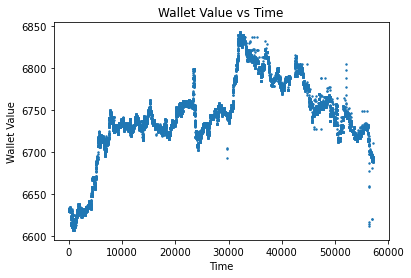

In [11]:
# verify findings
wallet_value = simulation(train_ticks, train_tick_pct_chng, avg_btm, avg_dtm, avg_pr)
returns = pct_chng(wallet_value[0], wallet_value[-1])
print("Done btm={} dtm={} pr={} returns={}".format(avg_btm, avg_dtm, avg_pr, returns))

fig, ax = plt.subplots()
ax.scatter(t_t, wallet_value, s=2)

ax.set(xlabel="Time", ylabel="Wallet Value", title="Wallet Value vs Time")
plt.savefig(out/"wallet_value.png")
plt.show()

(33205.79, 33205.81, 33231.99, 33232.01, 33231.99)
(57153, 57158, 57163, 57168, 57173)
[6.023045979872359e-07, 0.0007884162440247744, 6.018297430901531e-07, -6.018293808913315e-07, 6.018297430901531e-07]


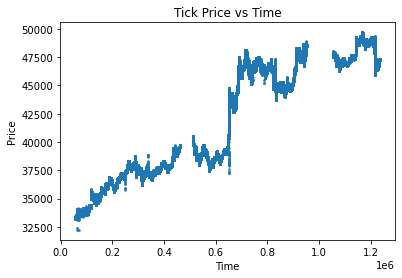

Returns: 0.424793989241033


In [12]:
print(validation_ticks[:5])
print(v_t[:5])
print(validation_ticks_pct_chng[:5])

fig, ax = plt.subplots()
ax.scatter(v_t, validation_ticks, s=2)

ax.set(xlabel="Time", ylabel="Price", title="Tick Price vs Time")
plt.show()

print("Returns: {}".format(pct_chng(validation_ticks[0], validation_ticks[-1])))

Done btm=0.01 dtm=10.51 pr=0.04 returns=0.21056072502925643


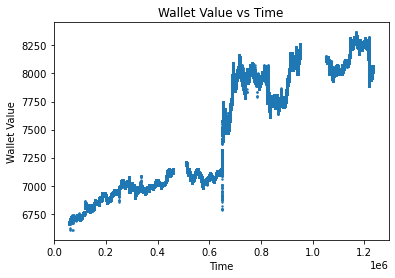

In [13]:
# out of sample test
wallet_value = simulation(validation_ticks, validation_ticks_pct_chng, avg_btm, avg_dtm, avg_pr)
returns_1 = pct_chng(wallet_value[0], wallet_value[-1])
print("Done btm={} dtm={} pr={} returns={}".format(avg_btm, avg_dtm, avg_pr, returns_1))

fig, ax = plt.subplots()
ax.scatter(v_t, wallet_value, s=2)

ax.set(xlabel="Time", ylabel="Wallet Value", title="Wallet Value vs Time")
plt.savefig(out/"wallet_value_validation.png")
plt.show()

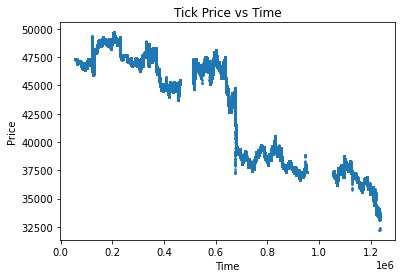

Returns: -0.2981441474688664


In [14]:
# synthetic test
synthetic_ticks = validation_ticks[::-1]
synthetic_times = v_t
synthetic_ticks_pct_chng = [ pct_chng(synthetic_ticks[i], synthetic_ticks[i+1]) for i in range(len(synthetic_ticks)-1) ]

fig, ax = plt.subplots()
ax.scatter(synthetic_times, synthetic_ticks, s=2)

ax.set(xlabel="Time", ylabel="Price", title="Tick Price vs Time")
plt.show()

print("Returns: {}".format(pct_chng(synthetic_ticks[0], synthetic_ticks[-1])))

Done btm=0.01 dtm=10.51 pr=0.04 returns=-0.1042499225984359


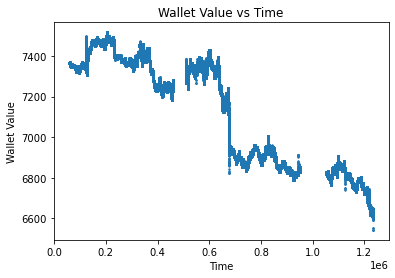

In [15]:
# out of sample synthetic test
wallet_value = simulation(synthetic_ticks, synthetic_ticks_pct_chng, avg_btm, avg_dtm, avg_pr)
returns_2 = pct_chng(wallet_value[0], wallet_value[-1])
print("Done btm={} dtm={} pr={} returns={}".format(avg_btm, avg_dtm, avg_pr, returns_2))

fig, ax = plt.subplots()
ax.scatter(synthetic_times, wallet_value, s=2)

ax.set(xlabel="Time", ylabel="Wallet Value", title="Wallet Value vs Time")
plt.show()

In [16]:
print("Market Returns : {}".format(1.424793131081579*(1-0.29814372473785933)))
print("My Returns : {}".format((1+returns_1)*(1+returns_2)))

Market Returns : 0.9999999999999999
My Returns : 1.0843598631442501
